## Inter-Process Communication (IPC)

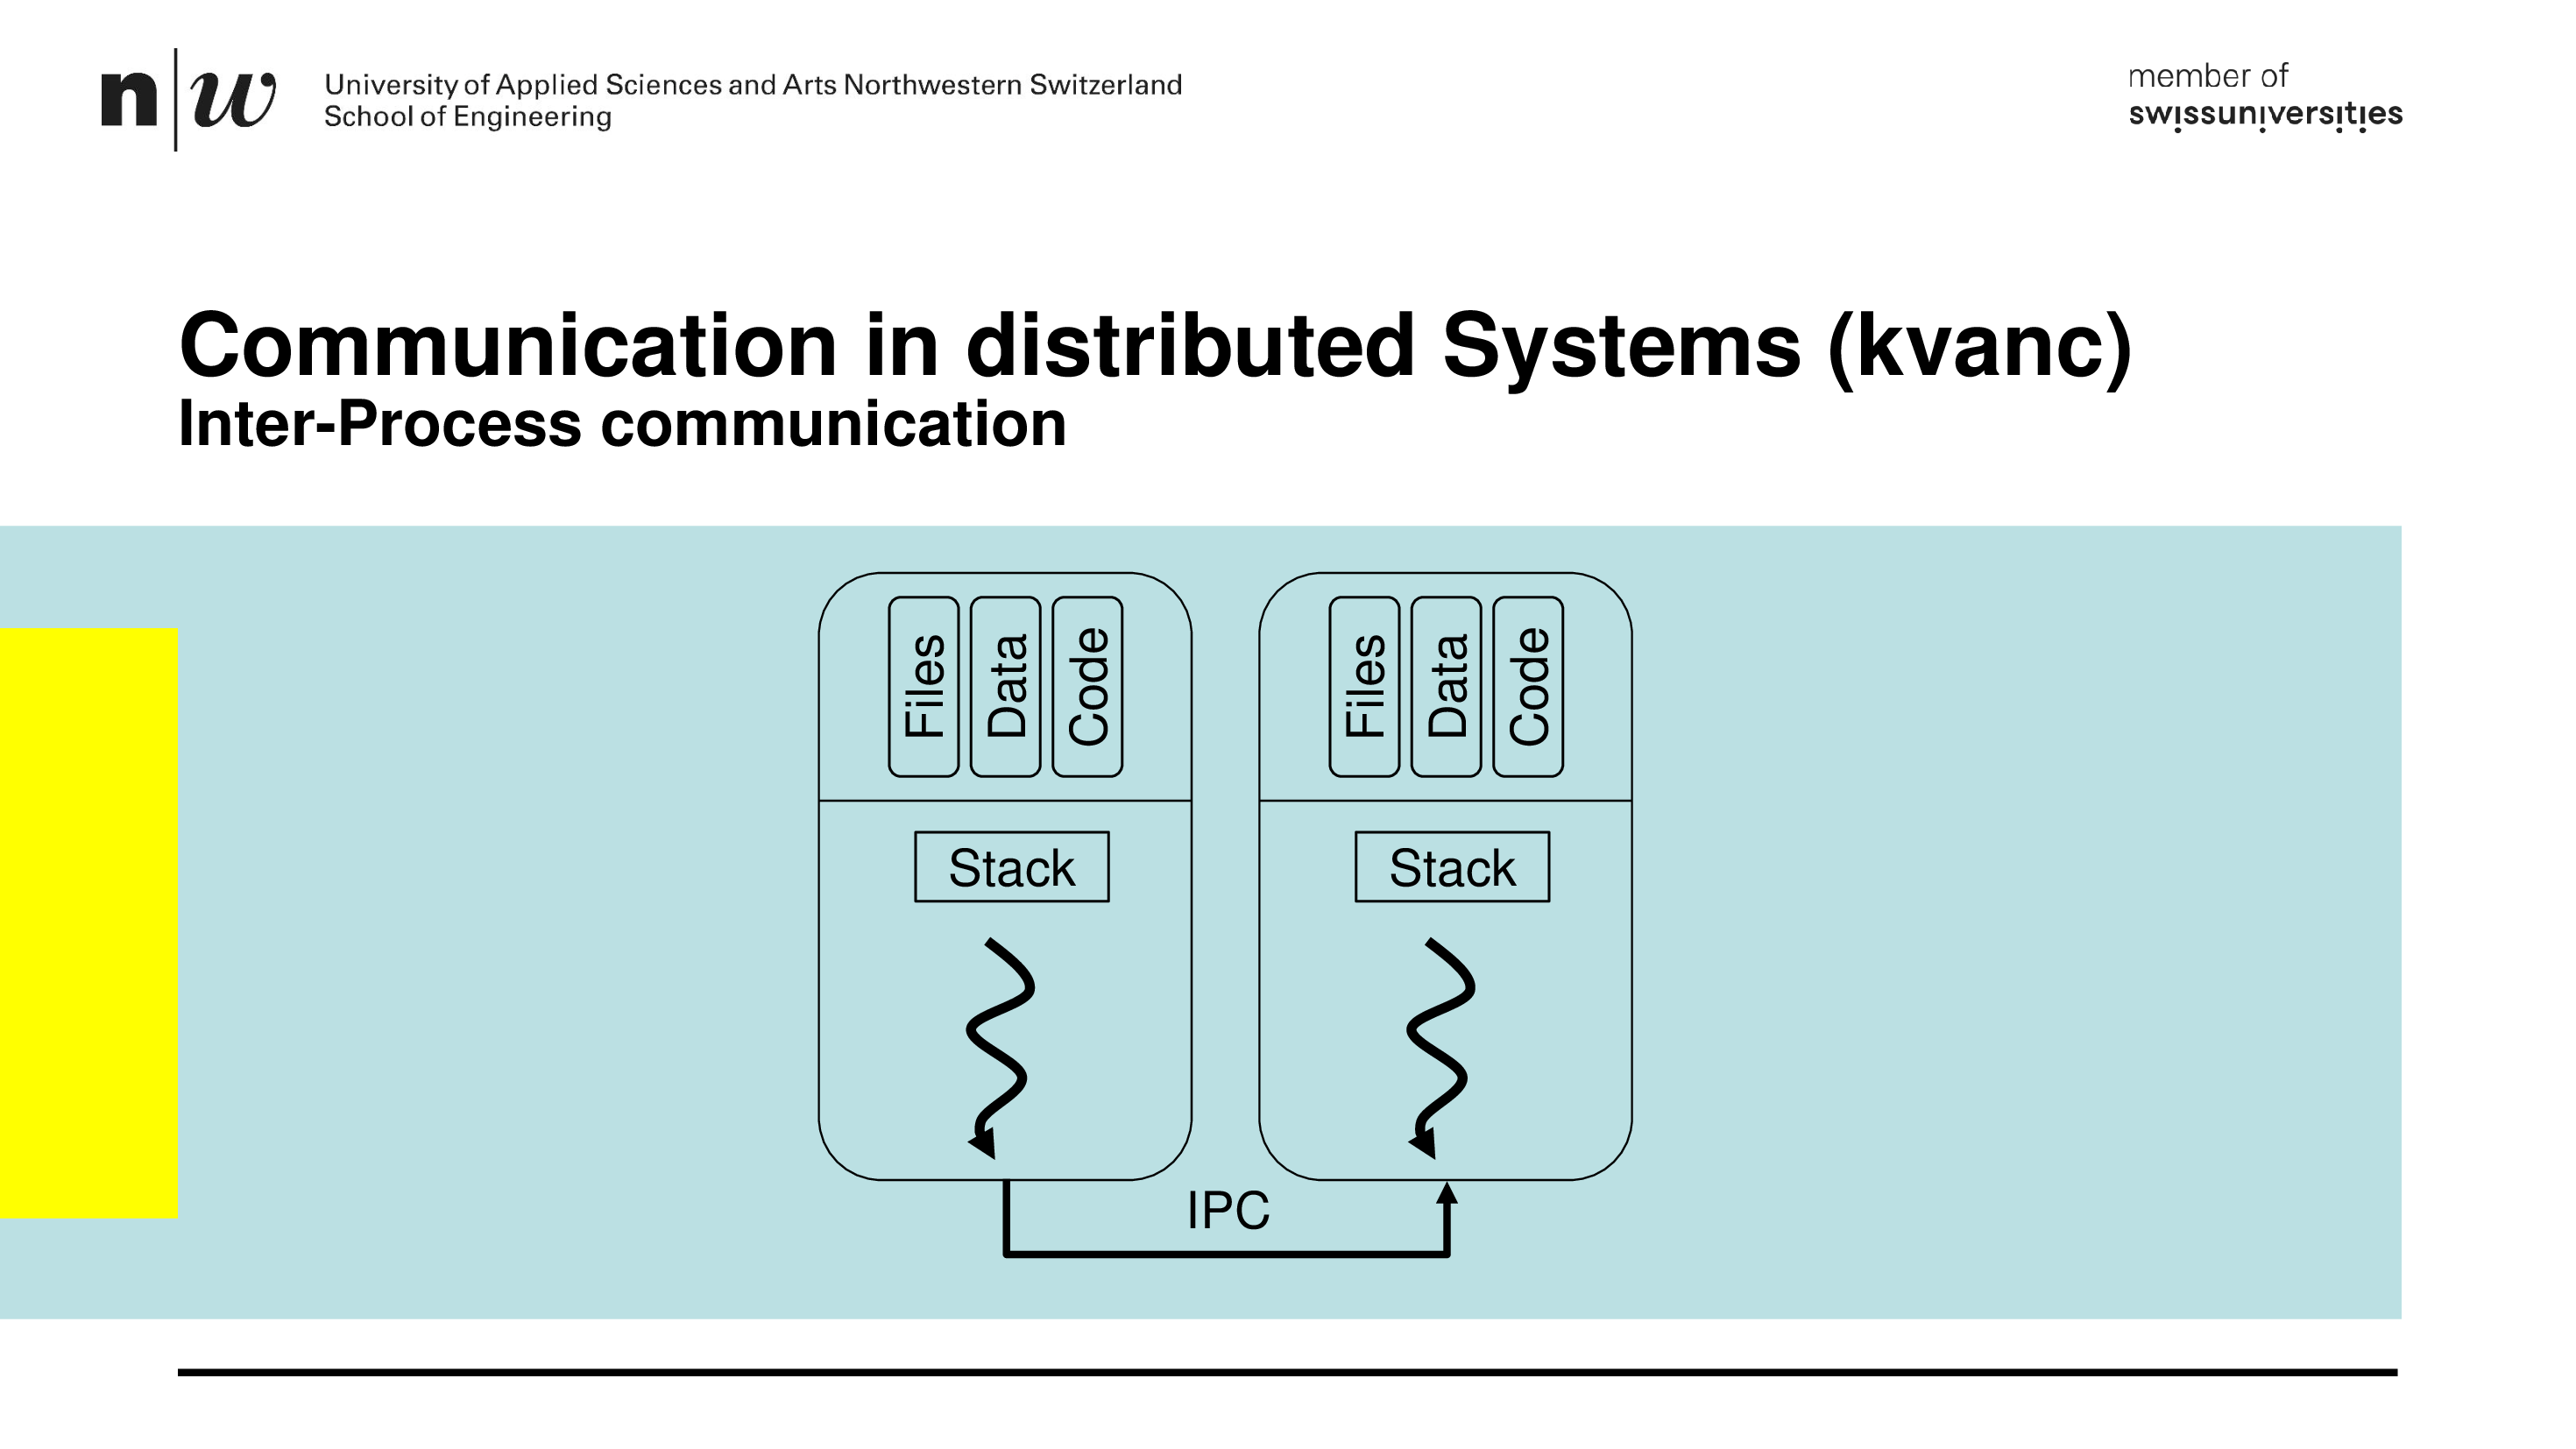

In [1]:
from wand.image import Image as WImage
WImage(filename="01_IPC.pdf[0]", resolution=200)

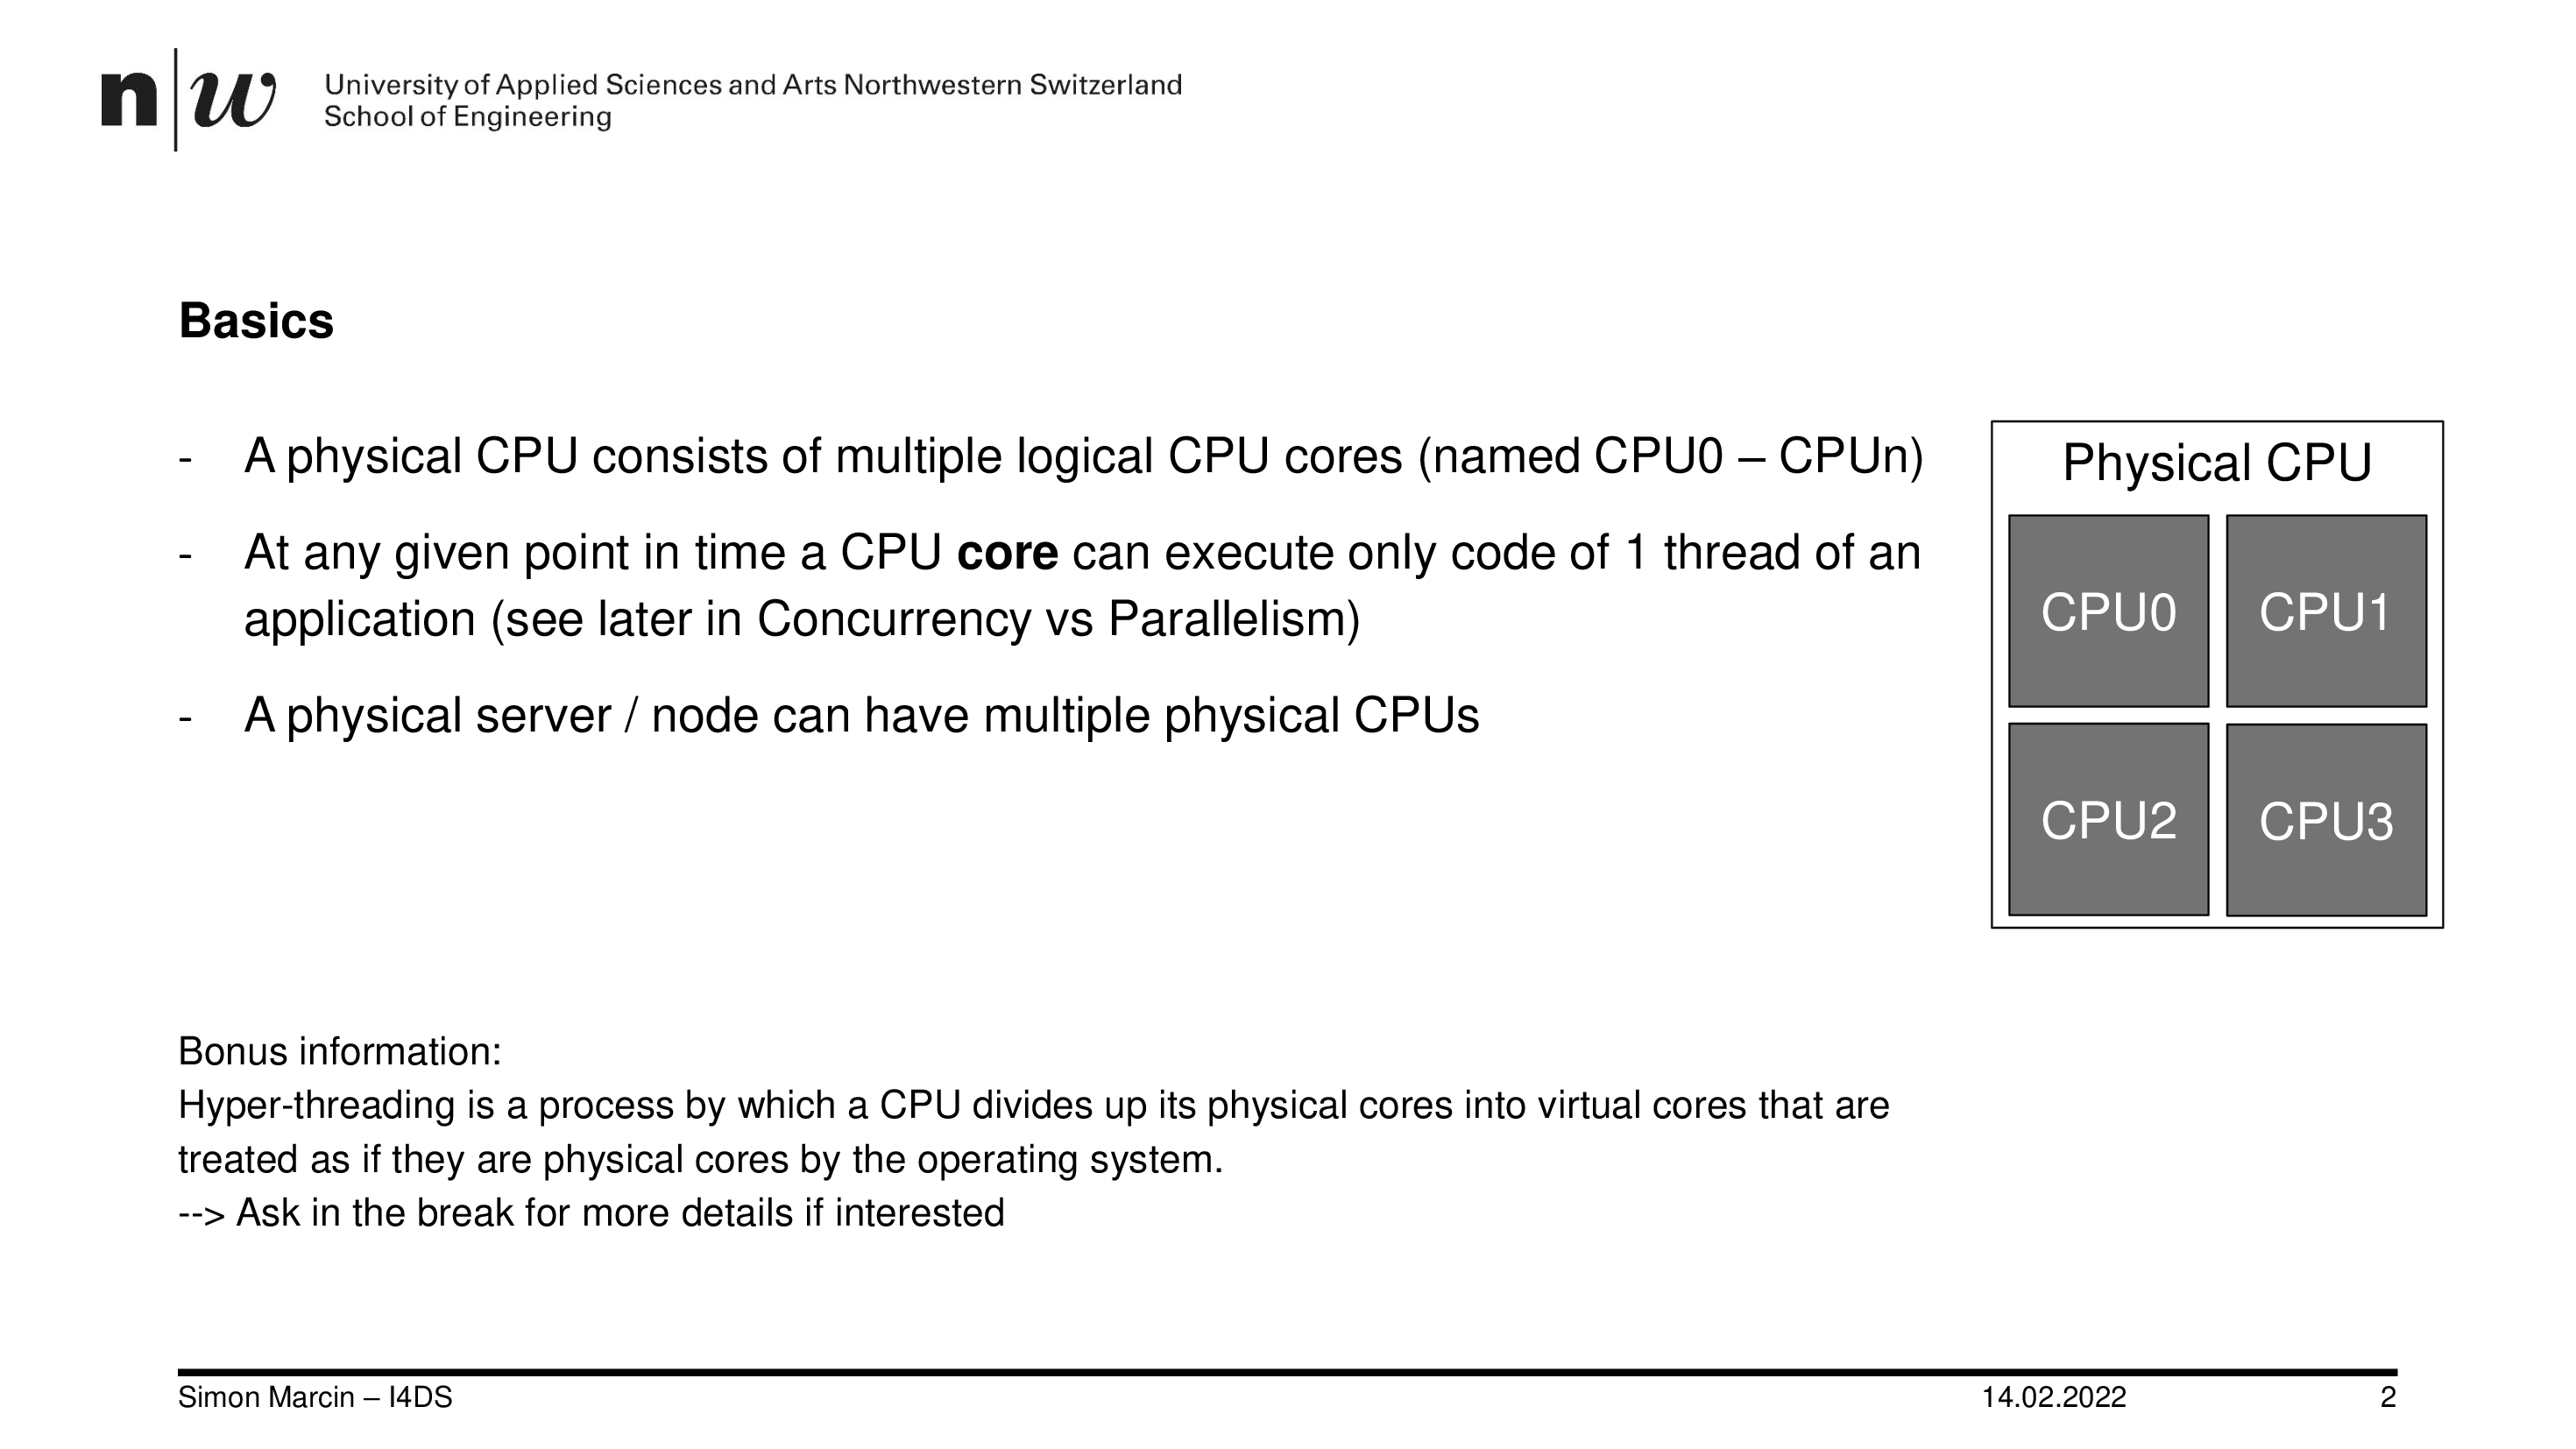

In [2]:
WImage(filename="01_IPC.pdf[1]", resolution=200)

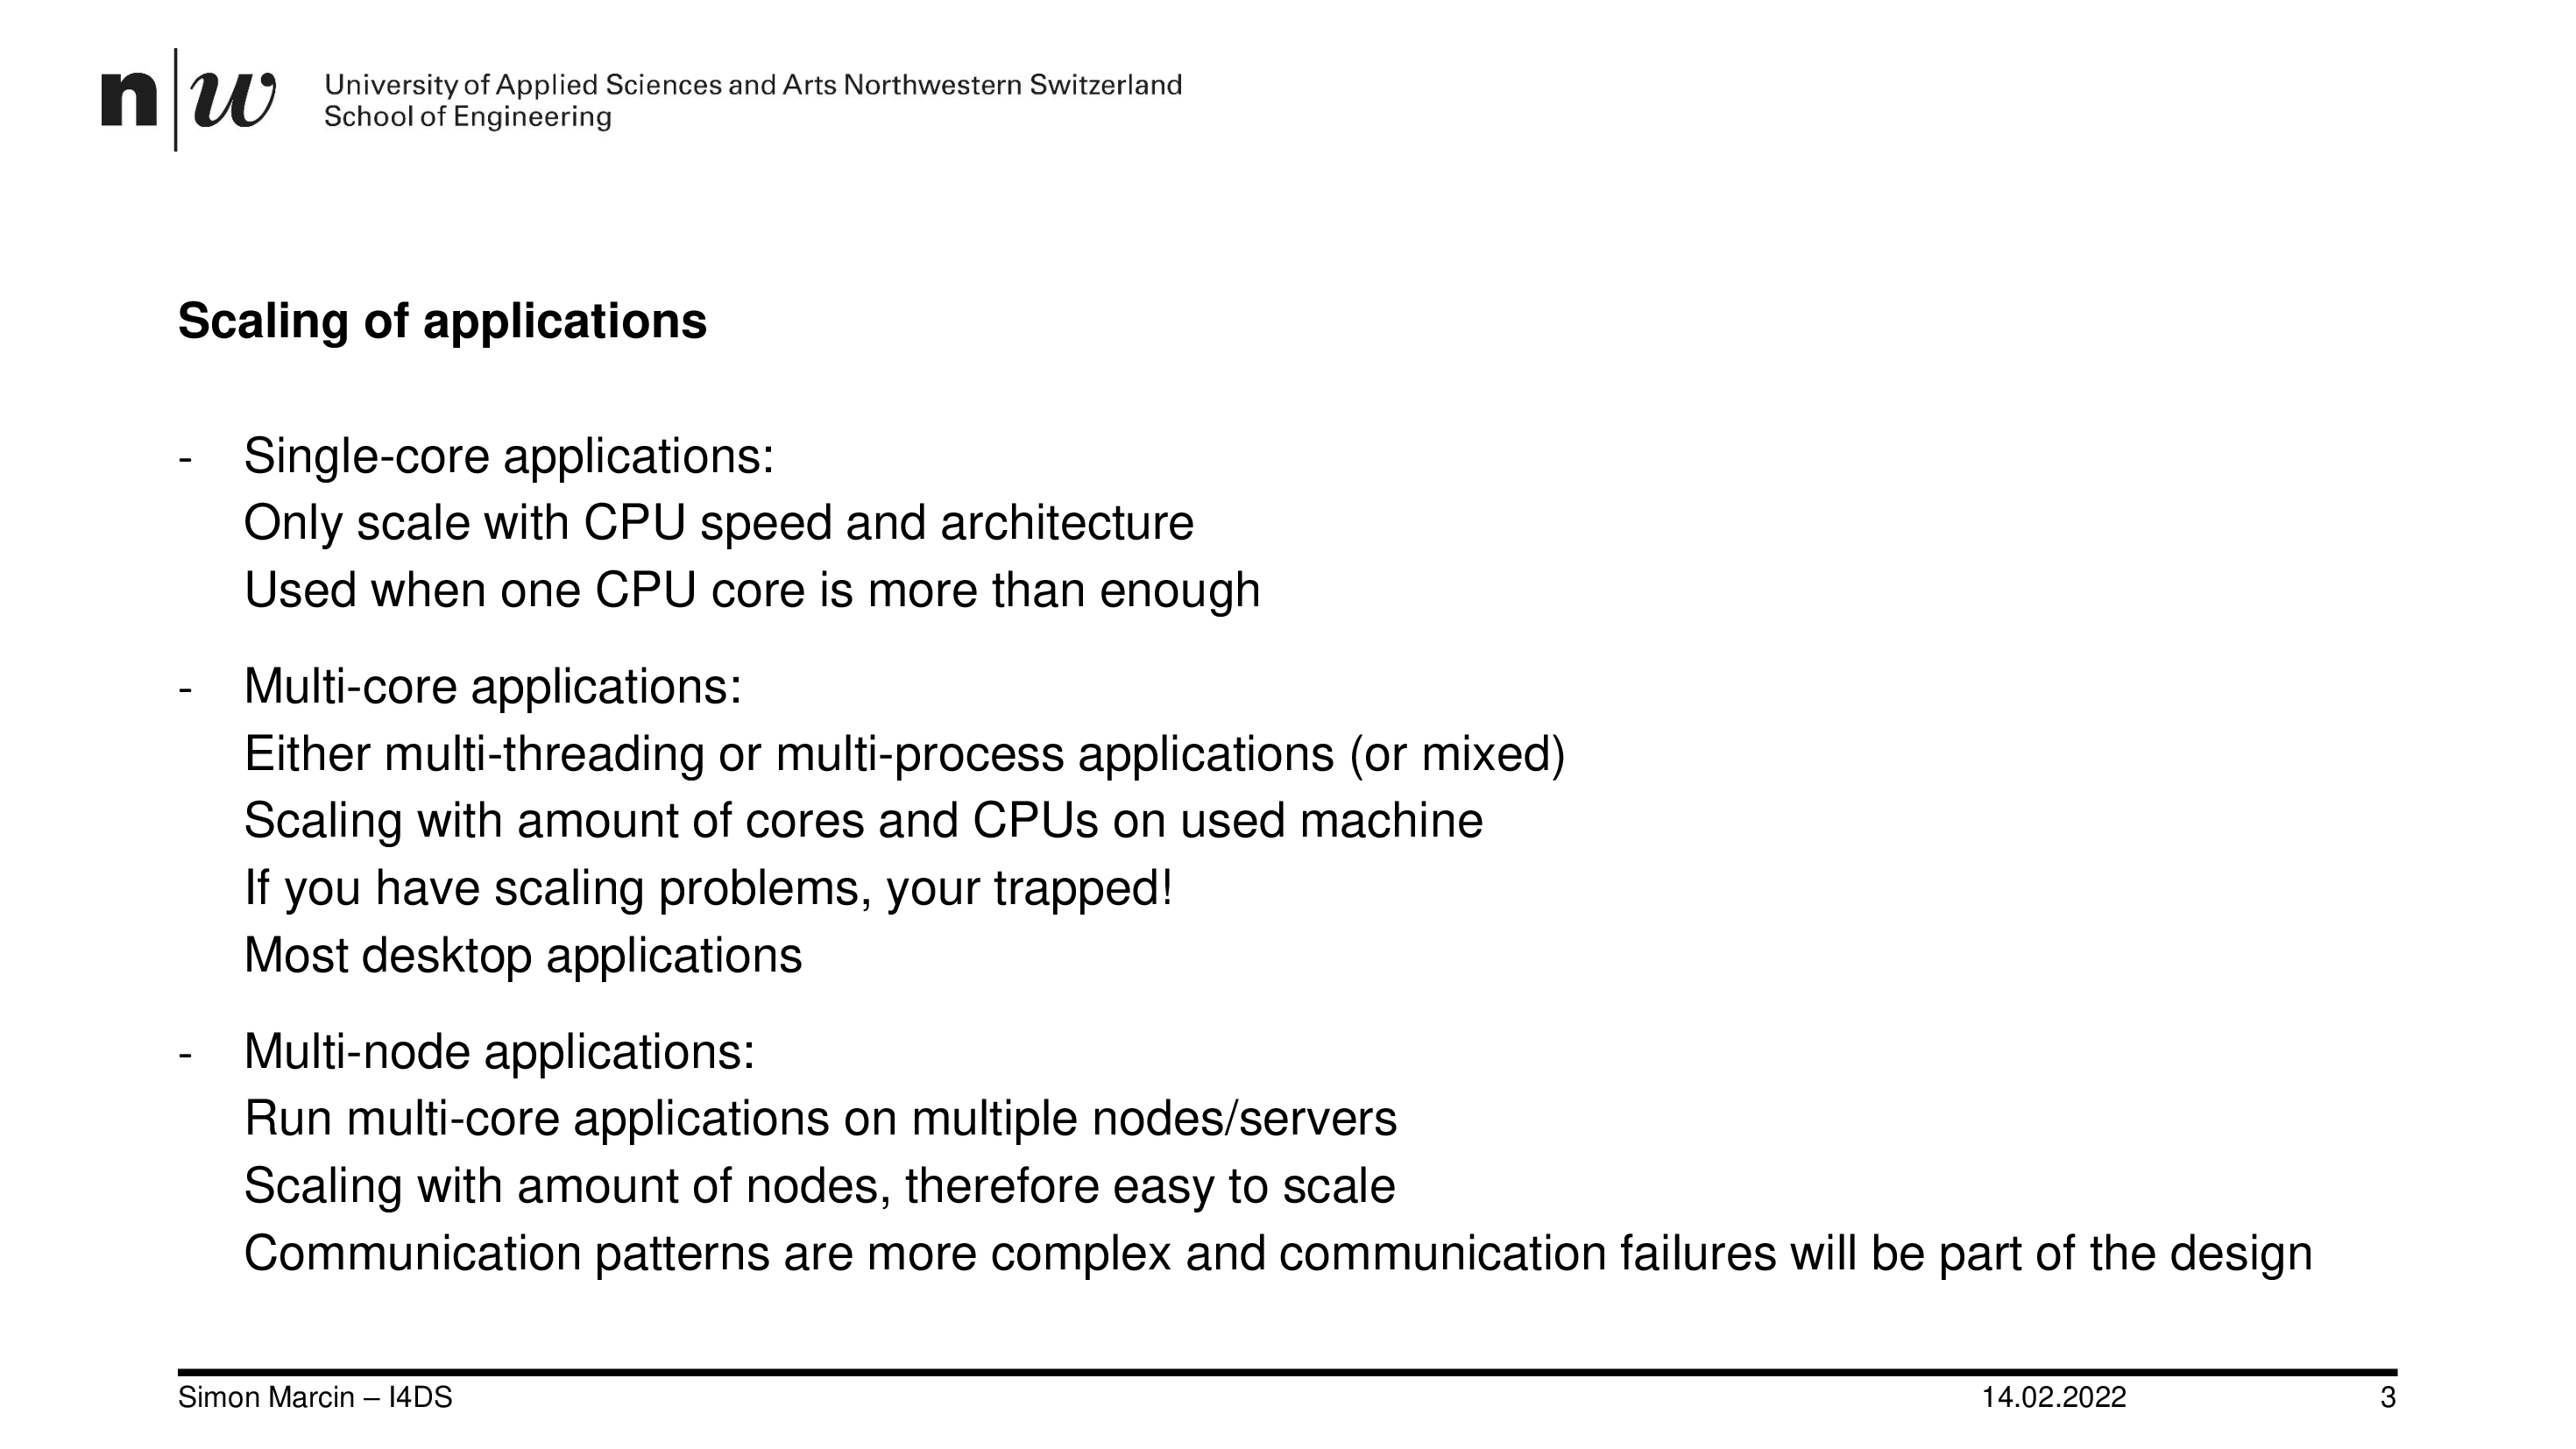

In [3]:
WImage(filename="01_IPC.pdf[2]", resolution=200)

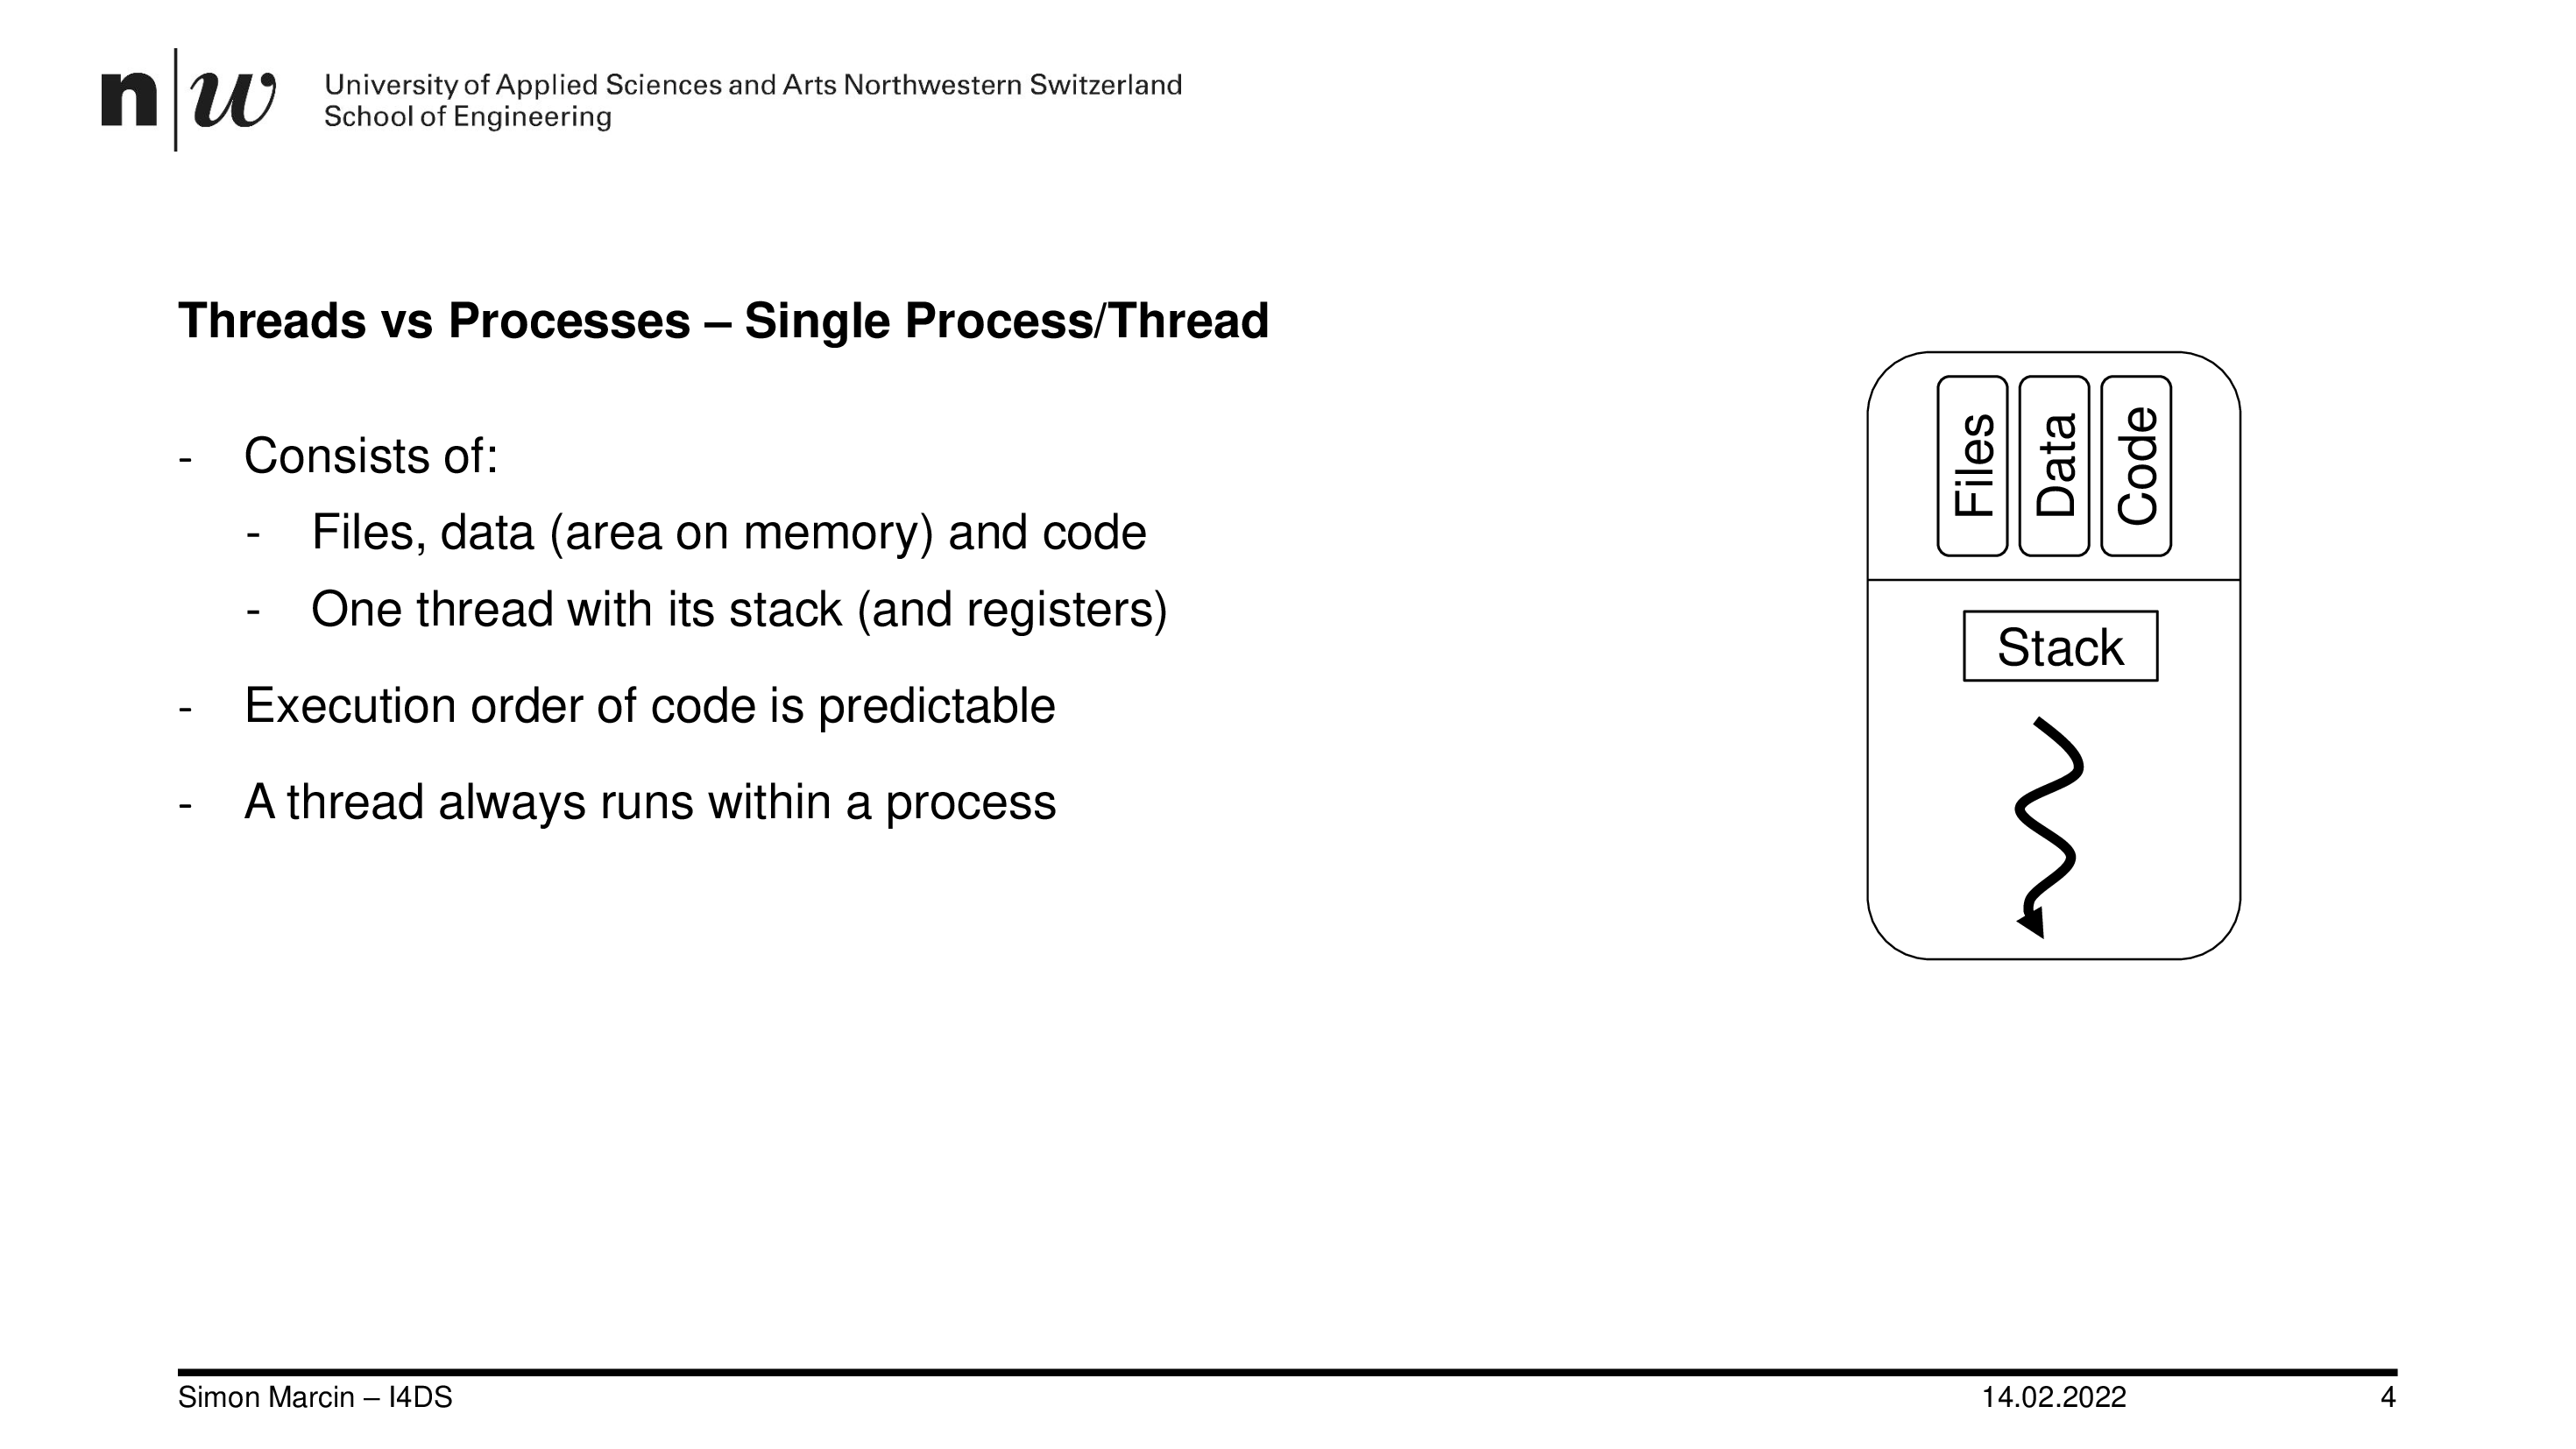

In [4]:
WImage(filename="01_IPC.pdf[3]", resolution=200)

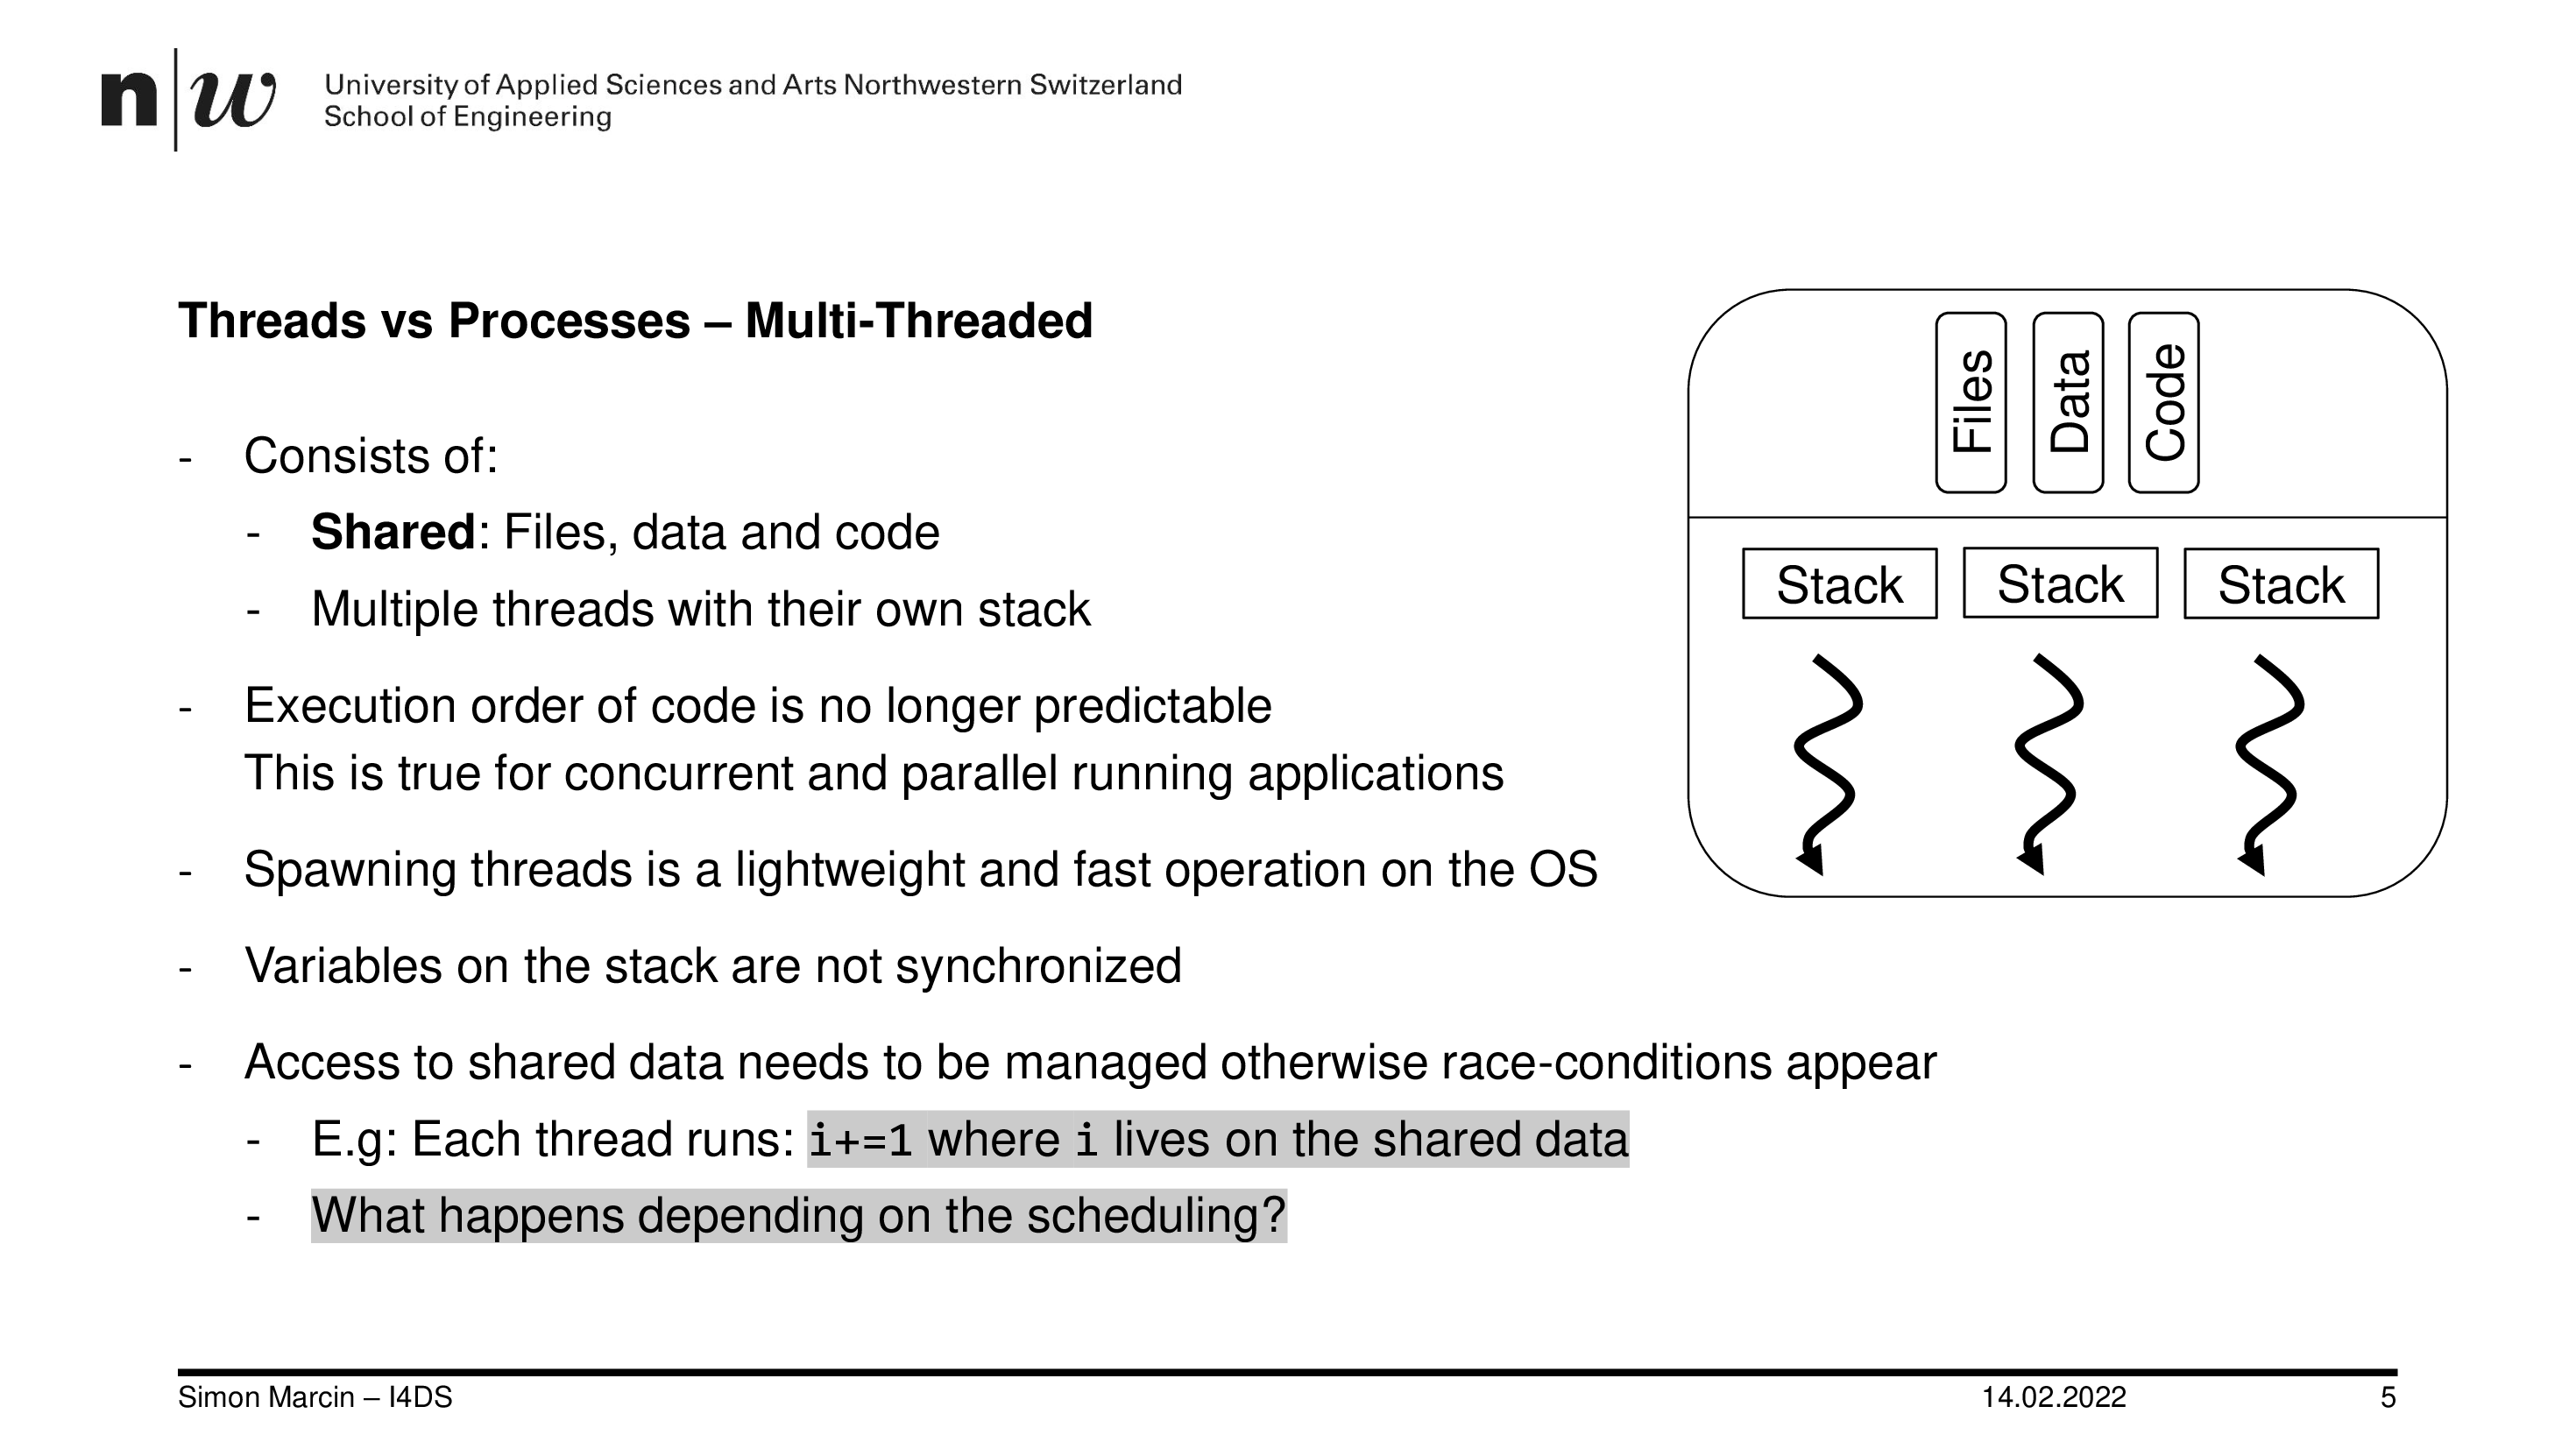

In [5]:
WImage(filename="01_IPC.pdf[4]", resolution=200)

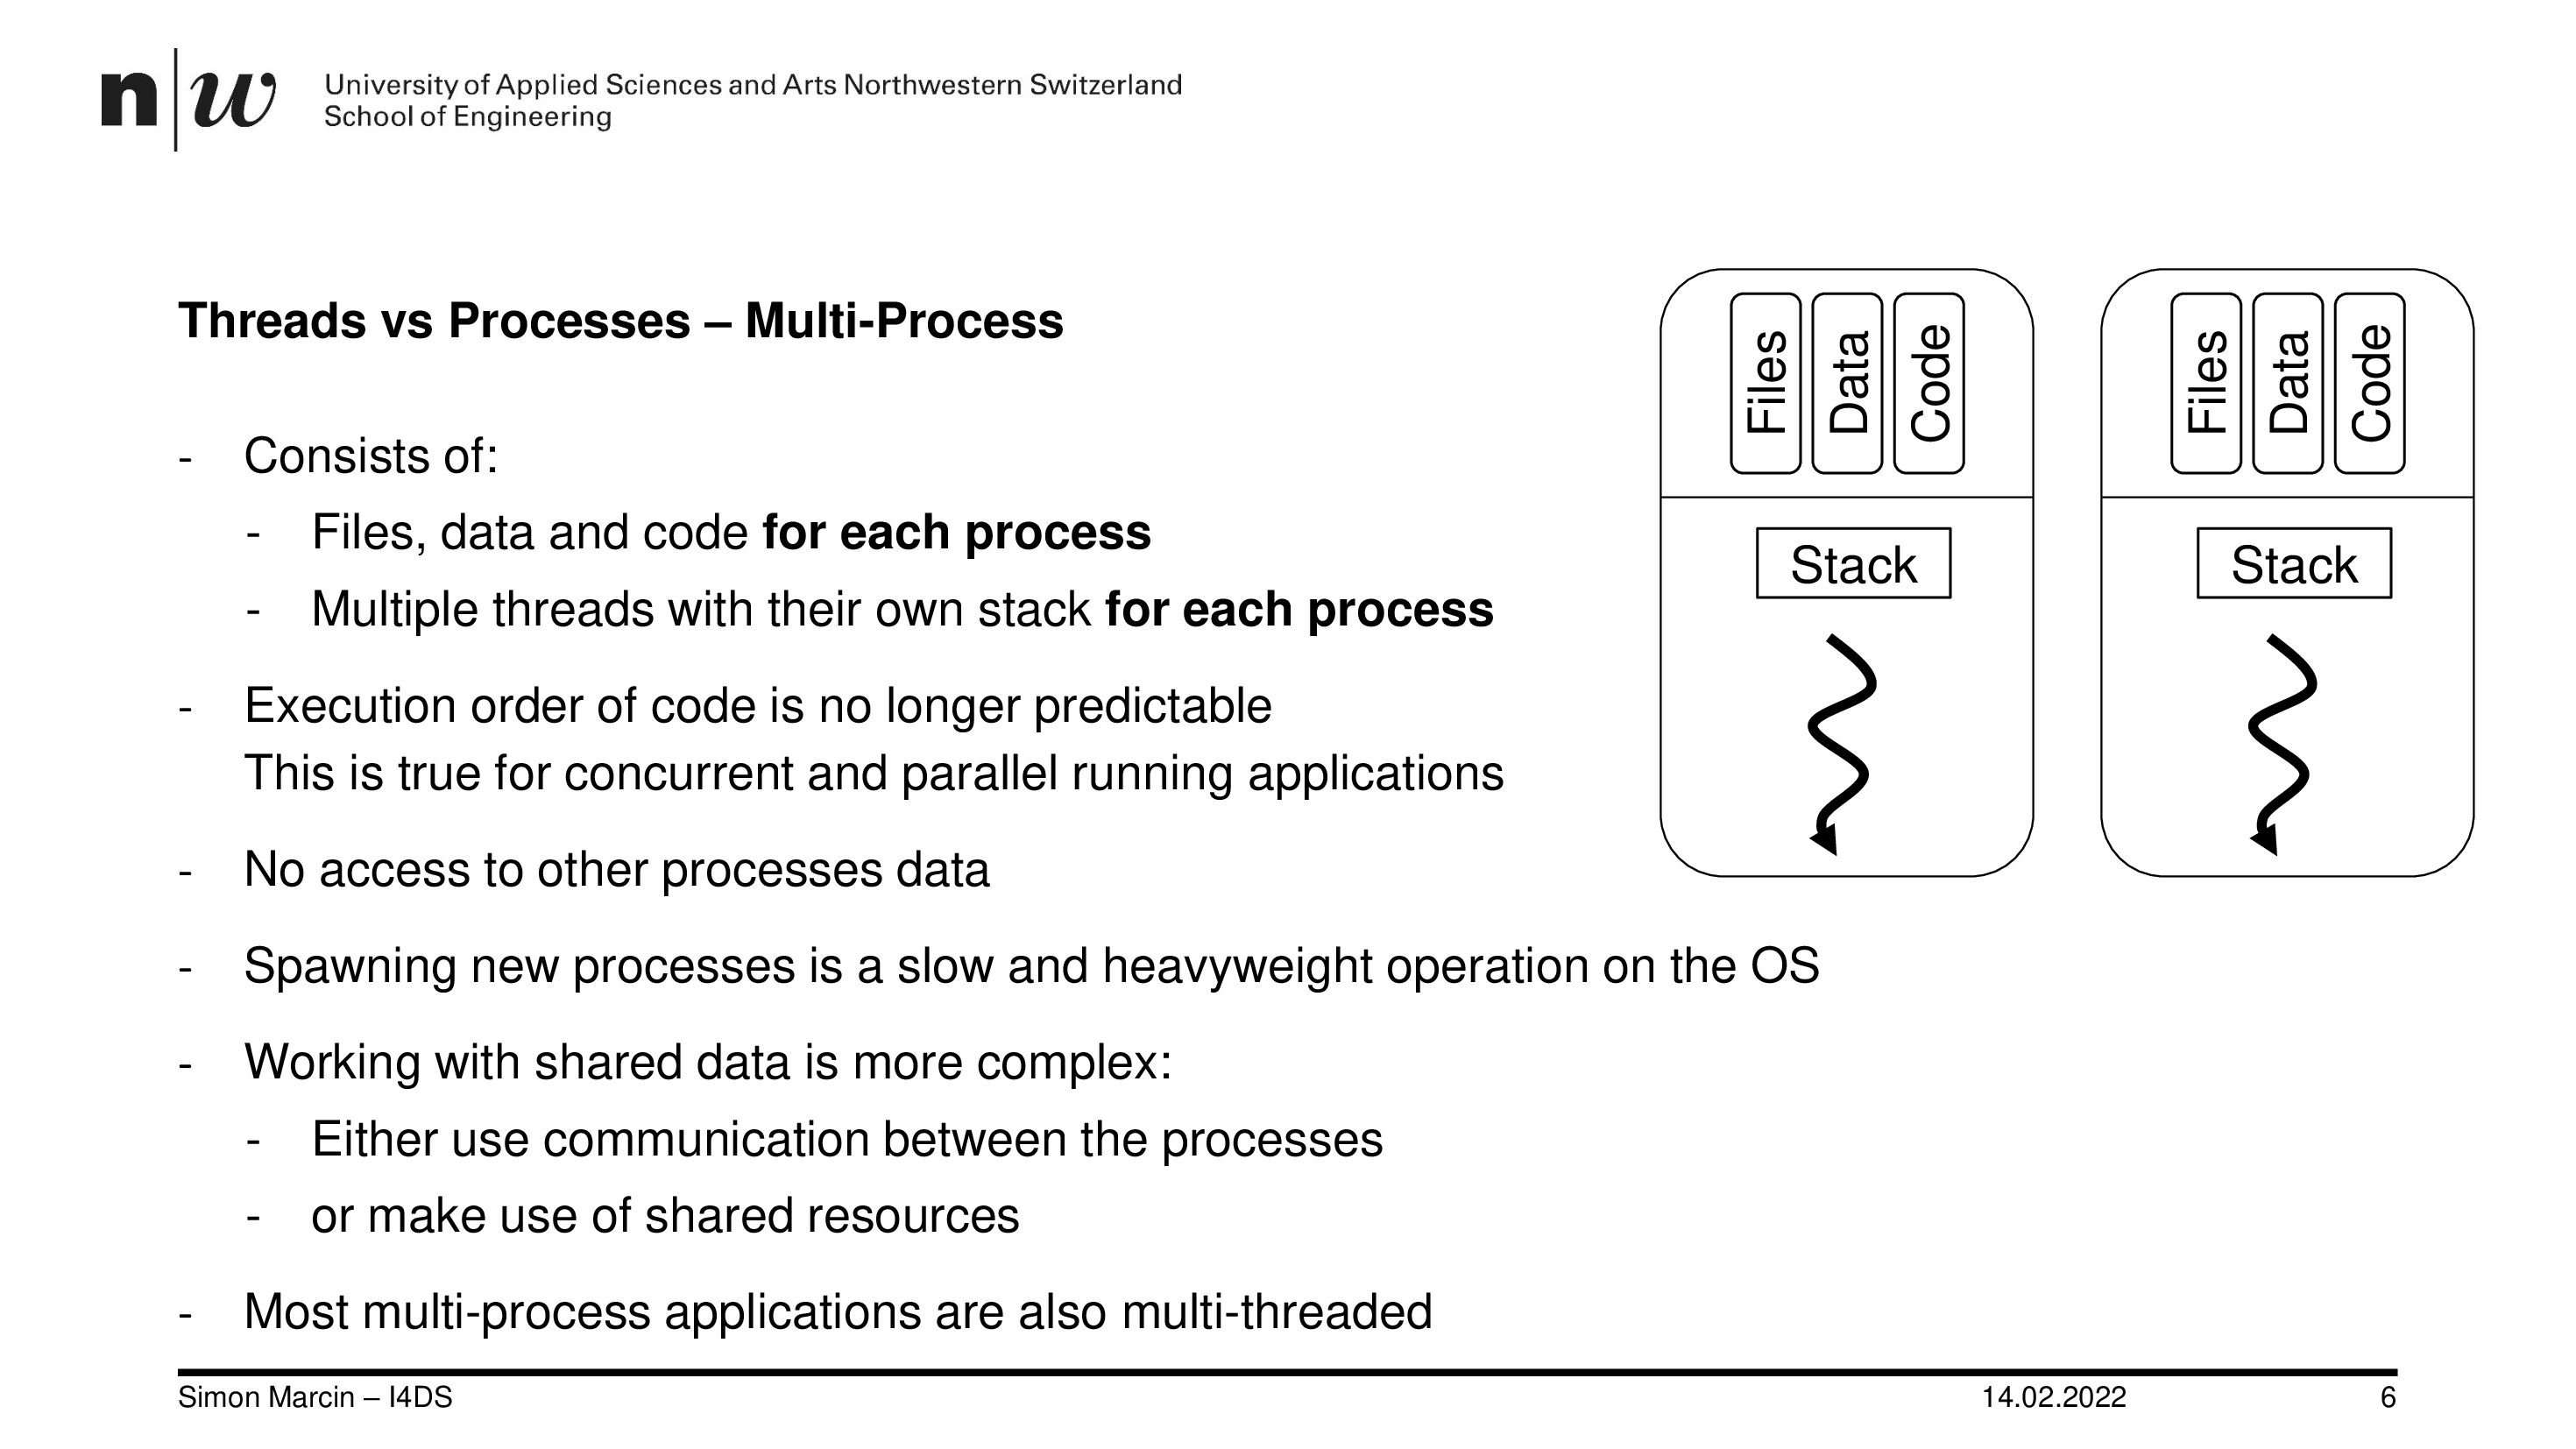

In [6]:
WImage(filename="01_IPC.pdf[5]", resolution=200)

### Race-Condition
The following code example shows the race-condition `i+=1` on shared memory. We therefore introduce a helper function `helper_start_n_processes` which starts N processes. Execute the Race-Condition cell multiple times, what do you expect and what do you observe?

In [12]:
#This is a helper function to start and close multiple processes
import multiprocessing
def helper_start_n_processes(n_procs, target, args=()):
    """
    n_procs: number of processes to start.
    target:  the function which gets executed n_procs times
    args:    tuple with all arguments to target function - has to be a tuple, even in case of one argument
    """
    procs = []
    # Open n_procs new processes and execute target function
    for i in range(n_procs):
        p = multiprocessing.Process(target=target, args=args)
        p.start()
        procs.append(p)
    # Properly close threads again
    for i in range(n_procs):
        procs[i].join()

In [13]:
#Race-Condition
def add_n_times_1(shared_num, n):
    """
    Execute shared_num+=1 n times where shared_num is multiprocessing.Value(integer).
    """
    for i in range(n):
        shared_num.value += 1

#Init a shared memory integer and start 2 processes running the function add_n_times
shared_num = multiprocessing.Value('i', 0)
helper_start_n_processes(2, add_n_times_1, args=(shared_num, 1000000 ))
print(f"Shared number is {shared_num.value} - is this correct?")

Shared number is 1330339 - is this correct?


What do you expect? Is this behaviour correct?

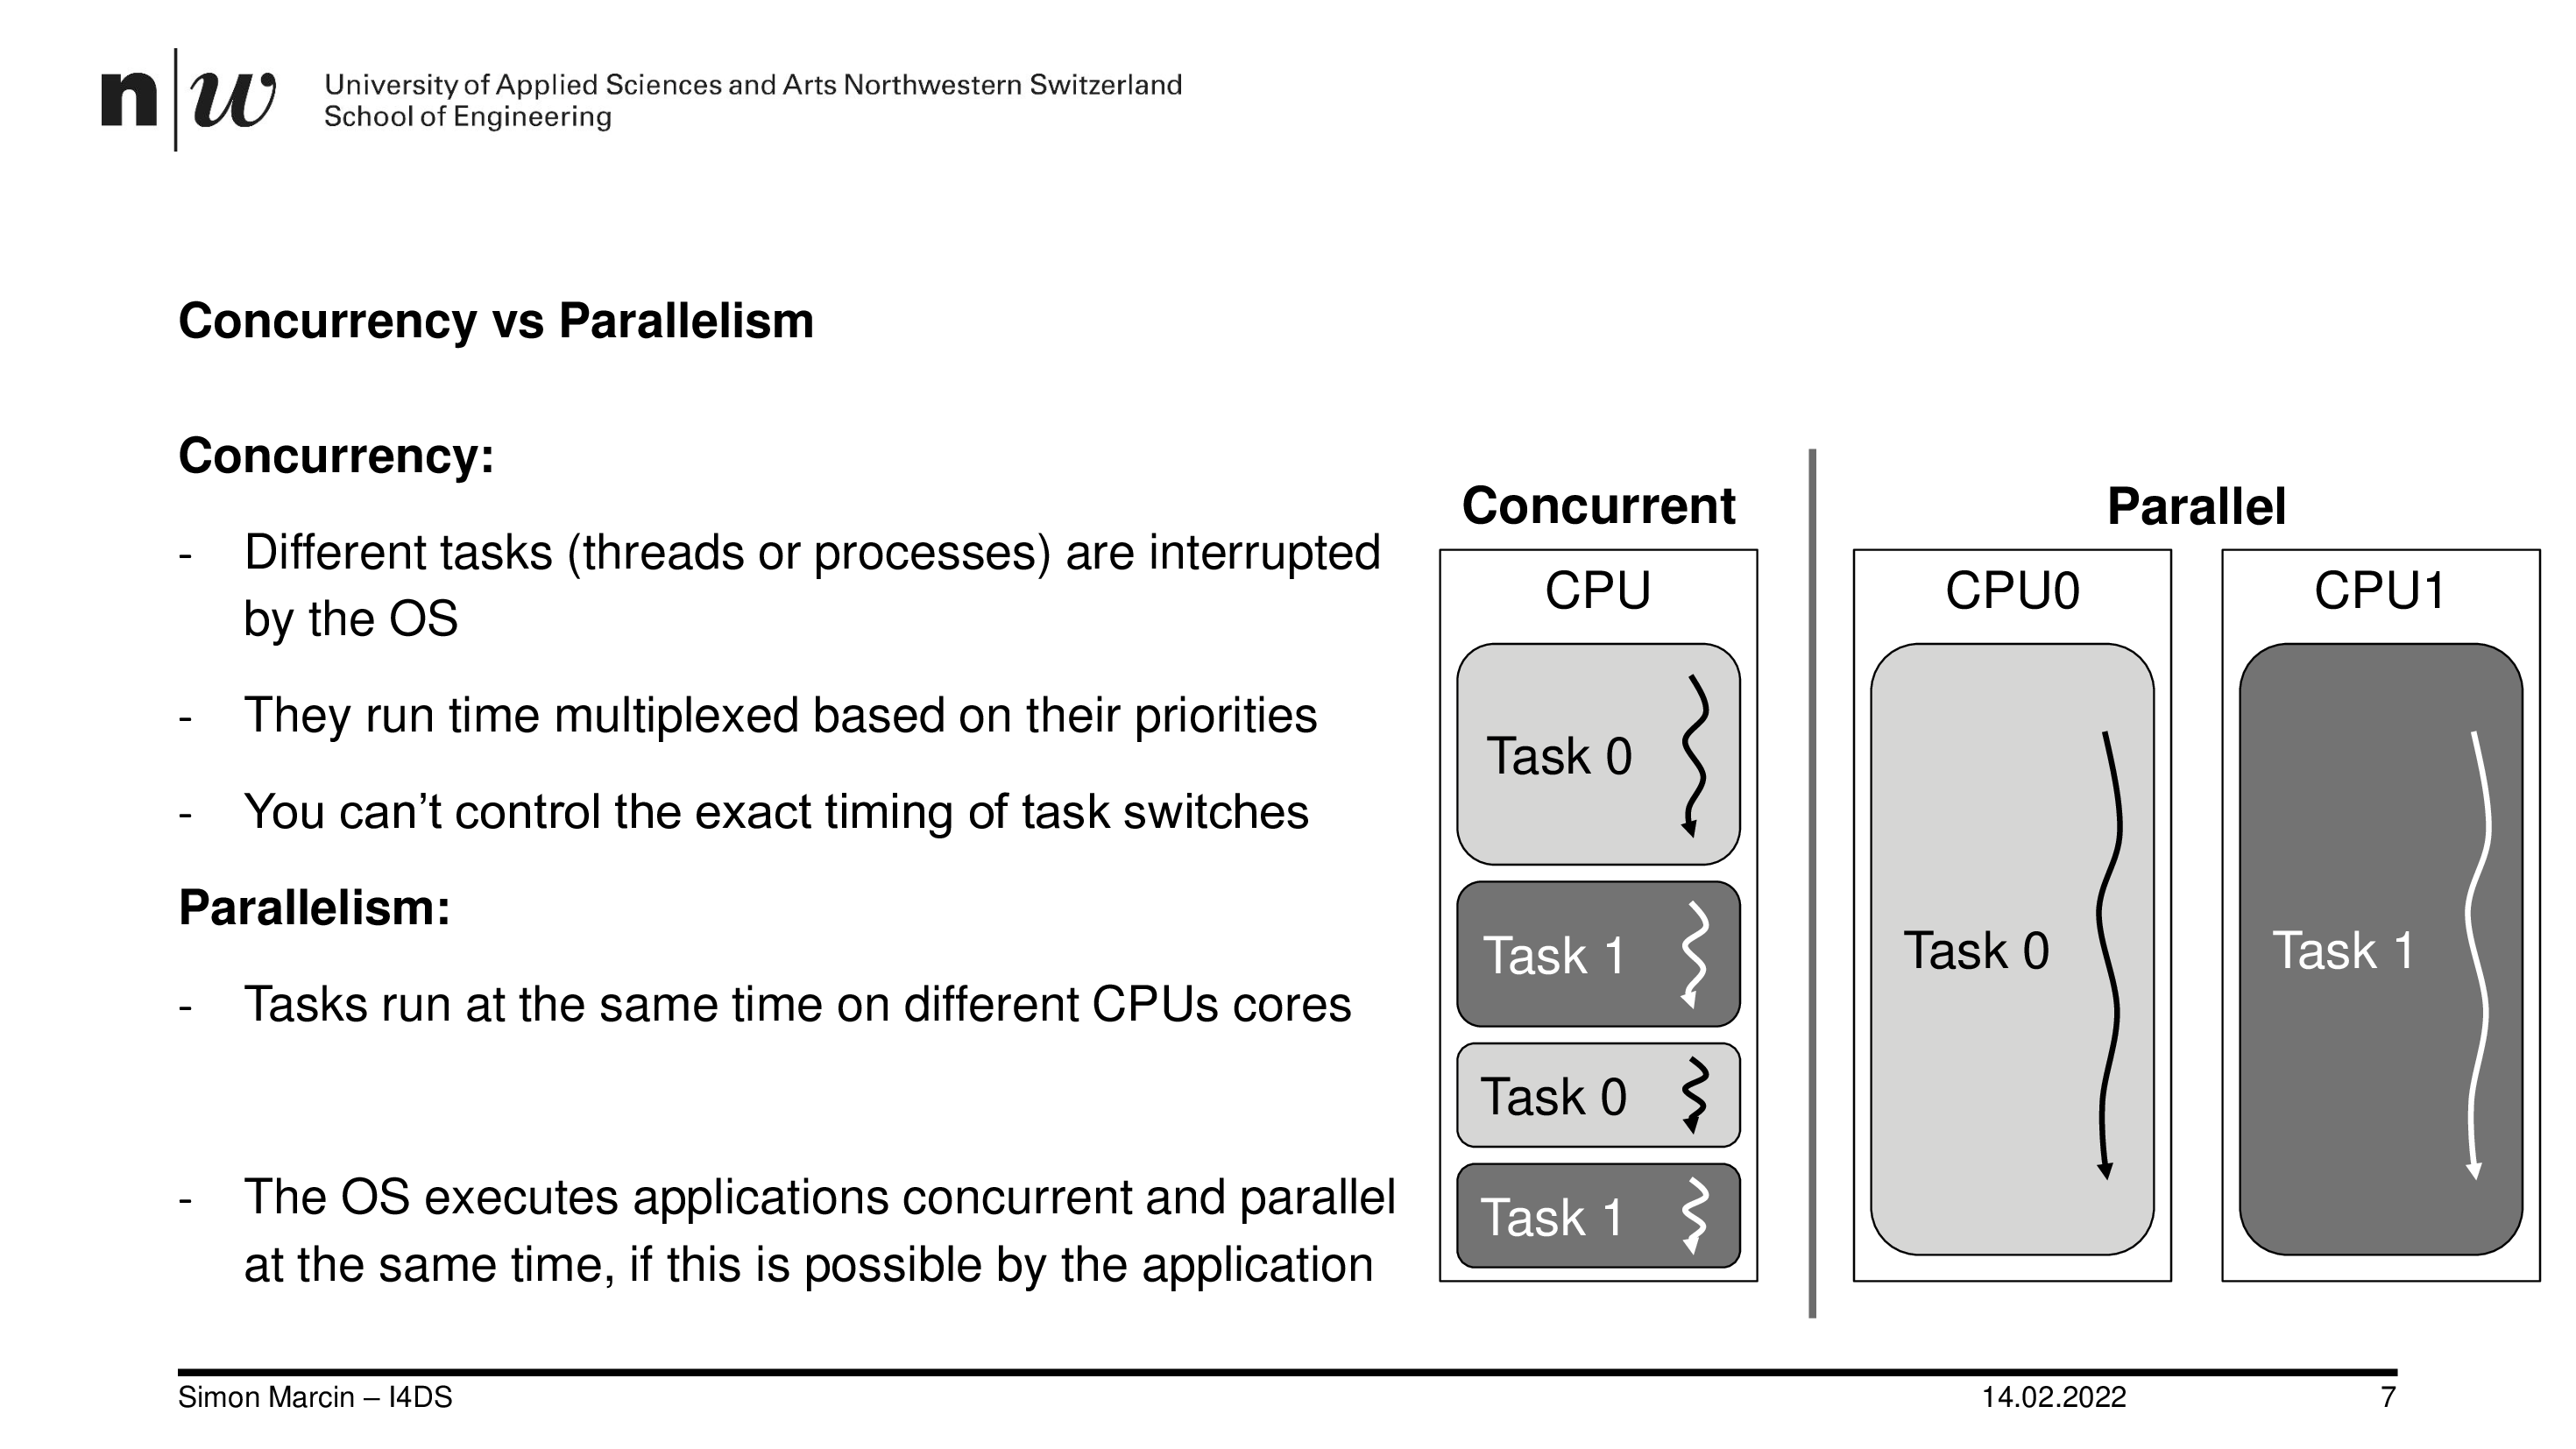

In [7]:
WImage(filename="01_IPC.pdf[6]", resolution=200)

#### Concurrency vs Parallelism
Python threads will always be executed concurrently but not parallel! This has to do with the Global Interpreter Lock (GIL) of Python. It's like a single Mutex within one Python Process and a running Thread has to own it. This is one of the reason why Python is so simple and works well if the code is I/O bound. CPU-bound code needs more effort like multi-processing to scale. This is perfect for us to show the concurrency vs parallelism timings.

In [15]:
#This is a helper function to start and close multiple threads
import threading
def helper_start_n_threads(n_threads, target, args=()):
    """
    n_threads: number of threads to start.
    target:    the function which gets executed n_threads times
    args:      tuple with all arguments to target function - has to be a tuple, even in case of one argument
    """
    threads = []
    # Open n new threads and execute target function
    for i in range(n_threads):
        t = threading.Thread(target=target, args=args)
        t.start()
        threads.append(t)
    # Properly close threads again
    for i in range(n_threads):
        threads[i].join()

First we define a function which accumulates N ascending numbers. The `%%time` cell magic prints some execution time values as well as the results of the cell.

In [16]:
#Accumulate all elements of range with size n and print results
def add_all_elements(n):
    result = 0
    for i in range(n):
        result += i
    print(f"I'm done counting - thread {threading.get_ident()}.")

In [17]:
%%time
add_all_elements(100000000)

I'm done counting - thread 140190765651776.
CPU times: user 5.49 s, sys: 0 ns, total: 5.49 s
Wall time: 5.49 s


The above cell runs within a single process and a single thread. The thread takes the GIL and runs through. The next cell will run the code divieded in 8 threads. Due to the Pythons GIL the code will not run in parallel but "only" concurrent.

In [19]:
%%time
helper_start_n_threads(8, add_all_elements, args=(int(100000000/8),))

I'm done counting - thread 140189242472192.
I'm done counting - thread 140189893125888.
I'm done counting - thread 140189493290752.
I'm done counting - thread 140189250864896.
I'm done counting - thread 140189276043008.
I'm done counting - thread 140189501683456.
I'm done counting - thread 140189267650304.
I'm done counting - thread 140189259257600.
CPU times: user 6.86 s, sys: 85.8 ms, total: 6.94 s
Wall time: 6.76 s


Is this result expected? What is the difference between this concurrent run and the single thread run?

Let's do the same execution but using 8 processes this time. This will run the code in parallel (and concurrent). What do you expect now (we have 16 CPU cores)? 

In [20]:
%%time
helper_start_n_processes(8, add_all_elements, args=(int(100000000/8),))

I'm done counting - thread 140190765651776.
I'm done counting - thread 140190765651776.
I'm done counting - thread 140190765651776.
I'm done counting - thread 140190765651776.
I'm done counting - thread 140190765651776.
I'm done counting - thread 140190765651776.
I'm done counting - thread 140190765651776.
I'm done counting - thread 140190765651776.
CPU times: user 8.96 ms, sys: 65.8 ms, total: 74.7 ms
Wall time: 1.27 s


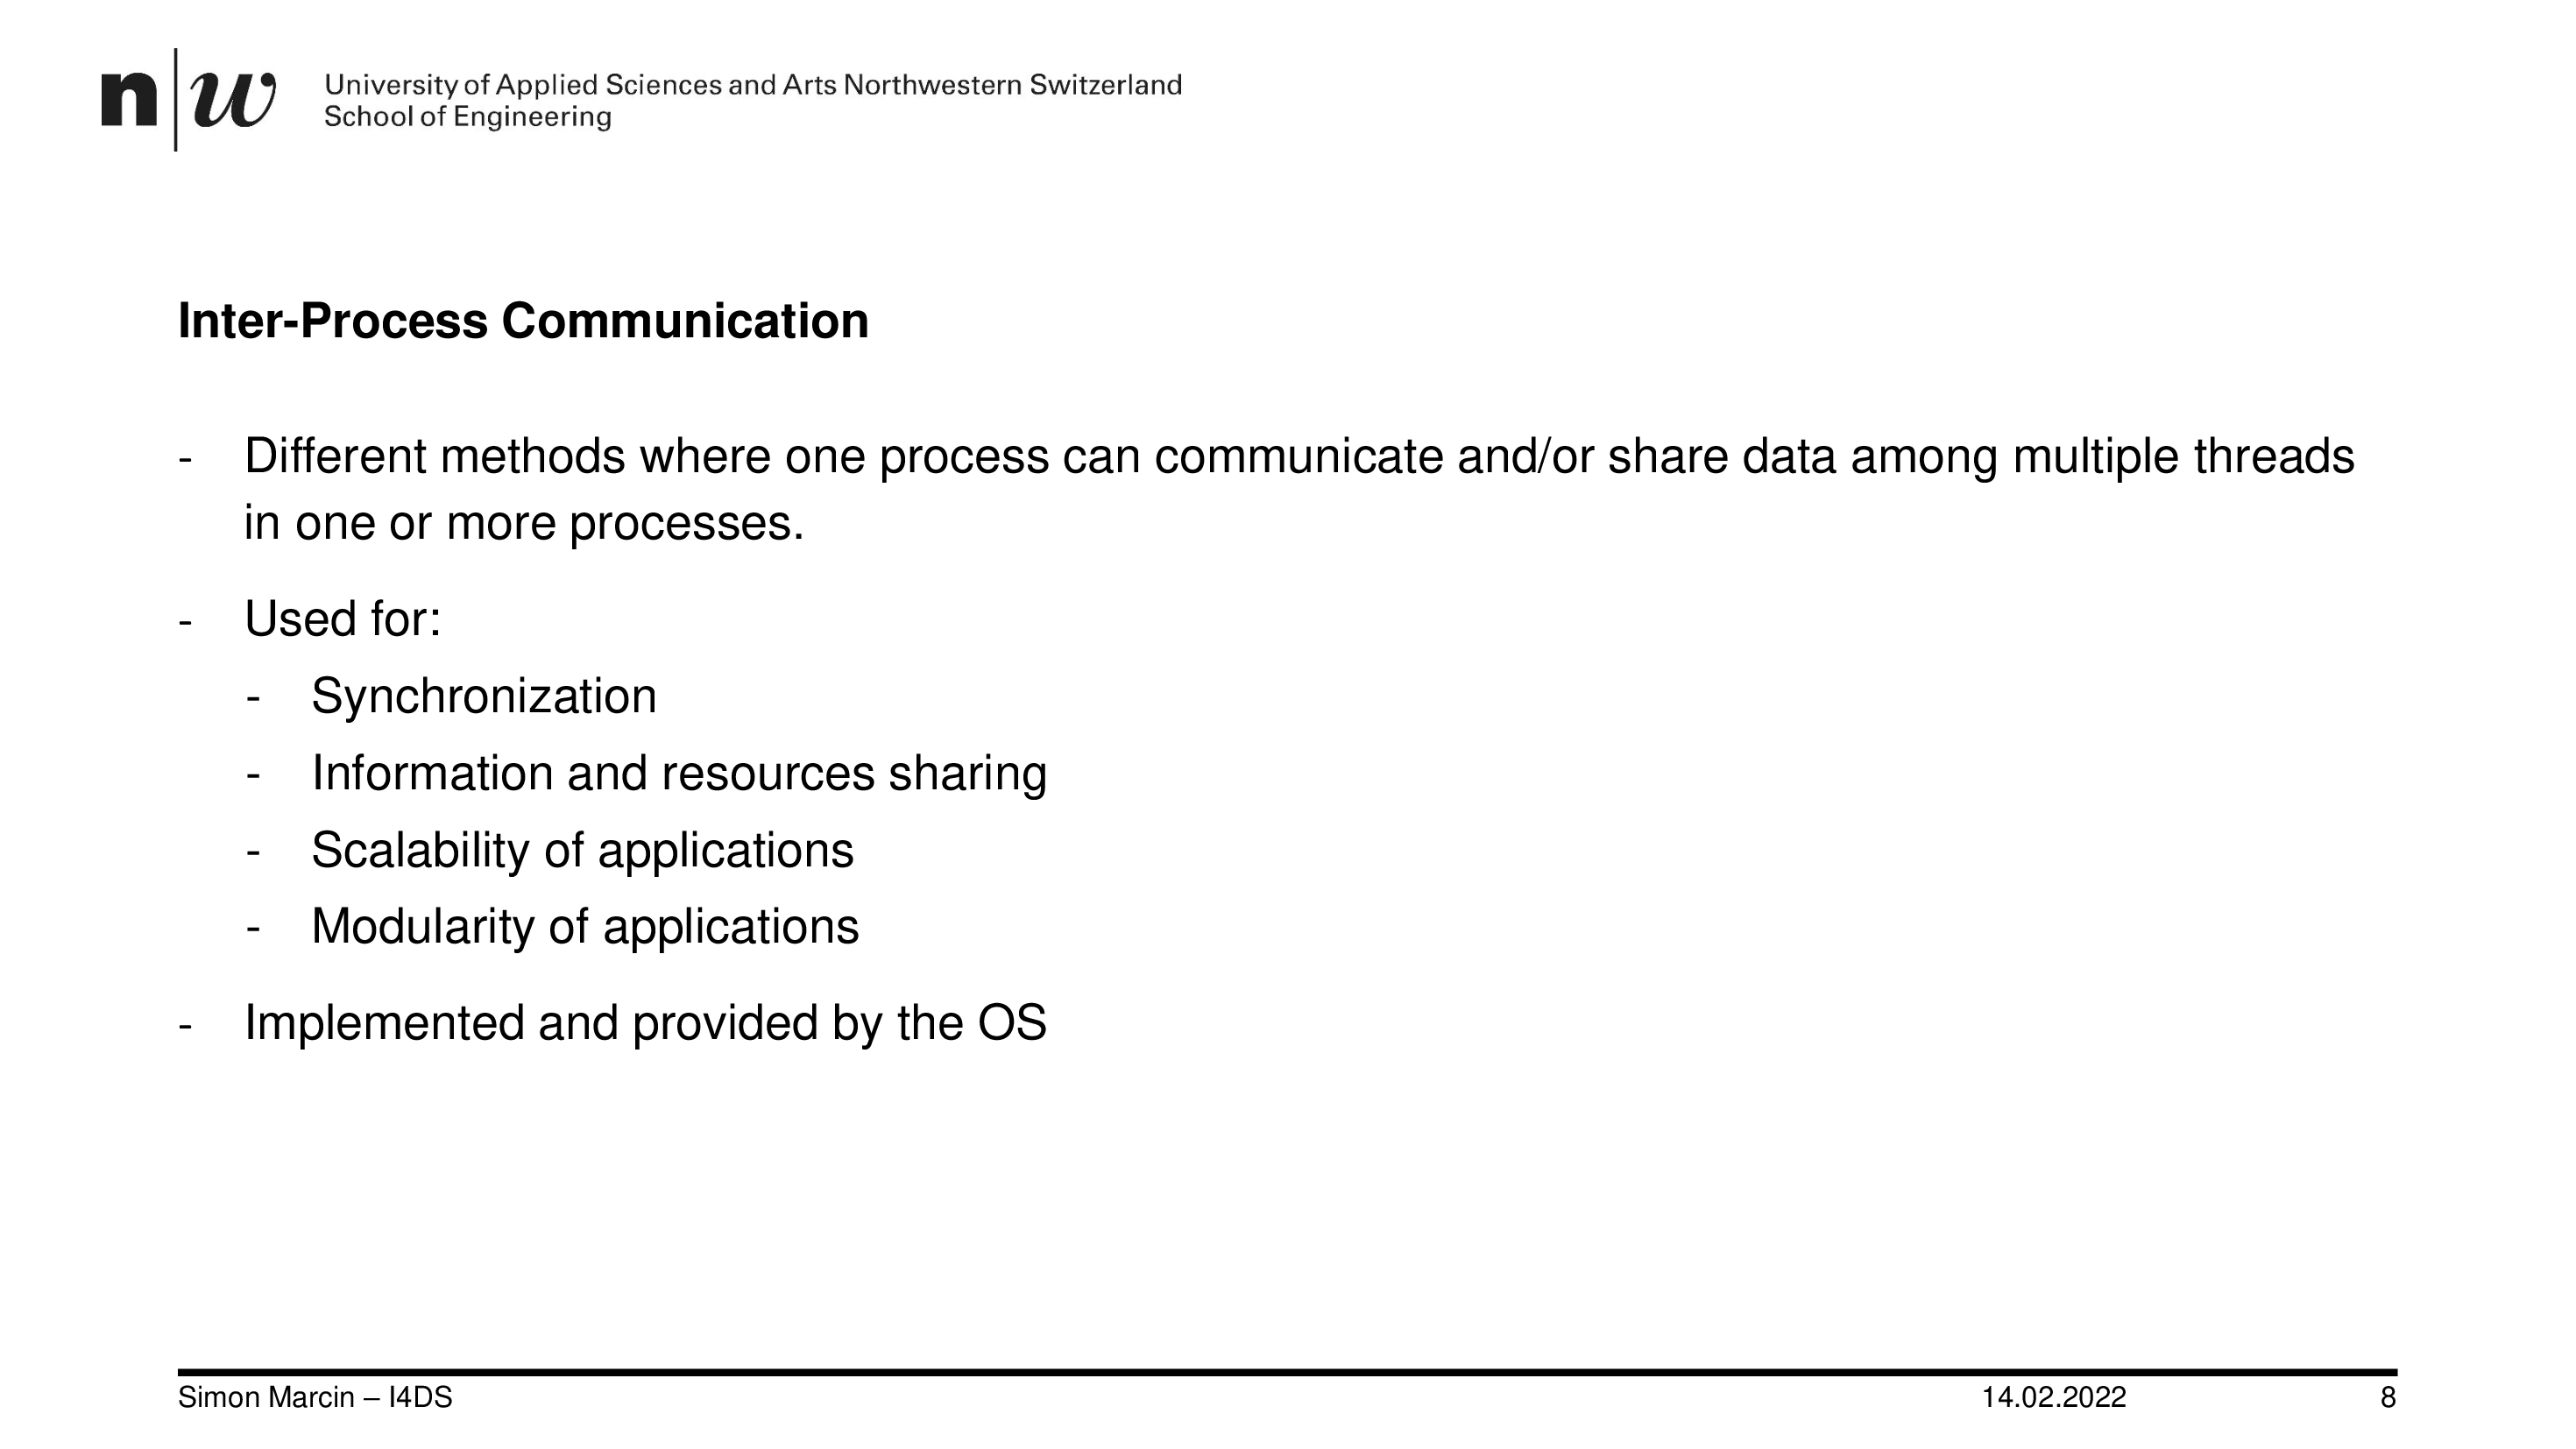

In [8]:
WImage(filename="01_IPC.pdf[7]", resolution=200)

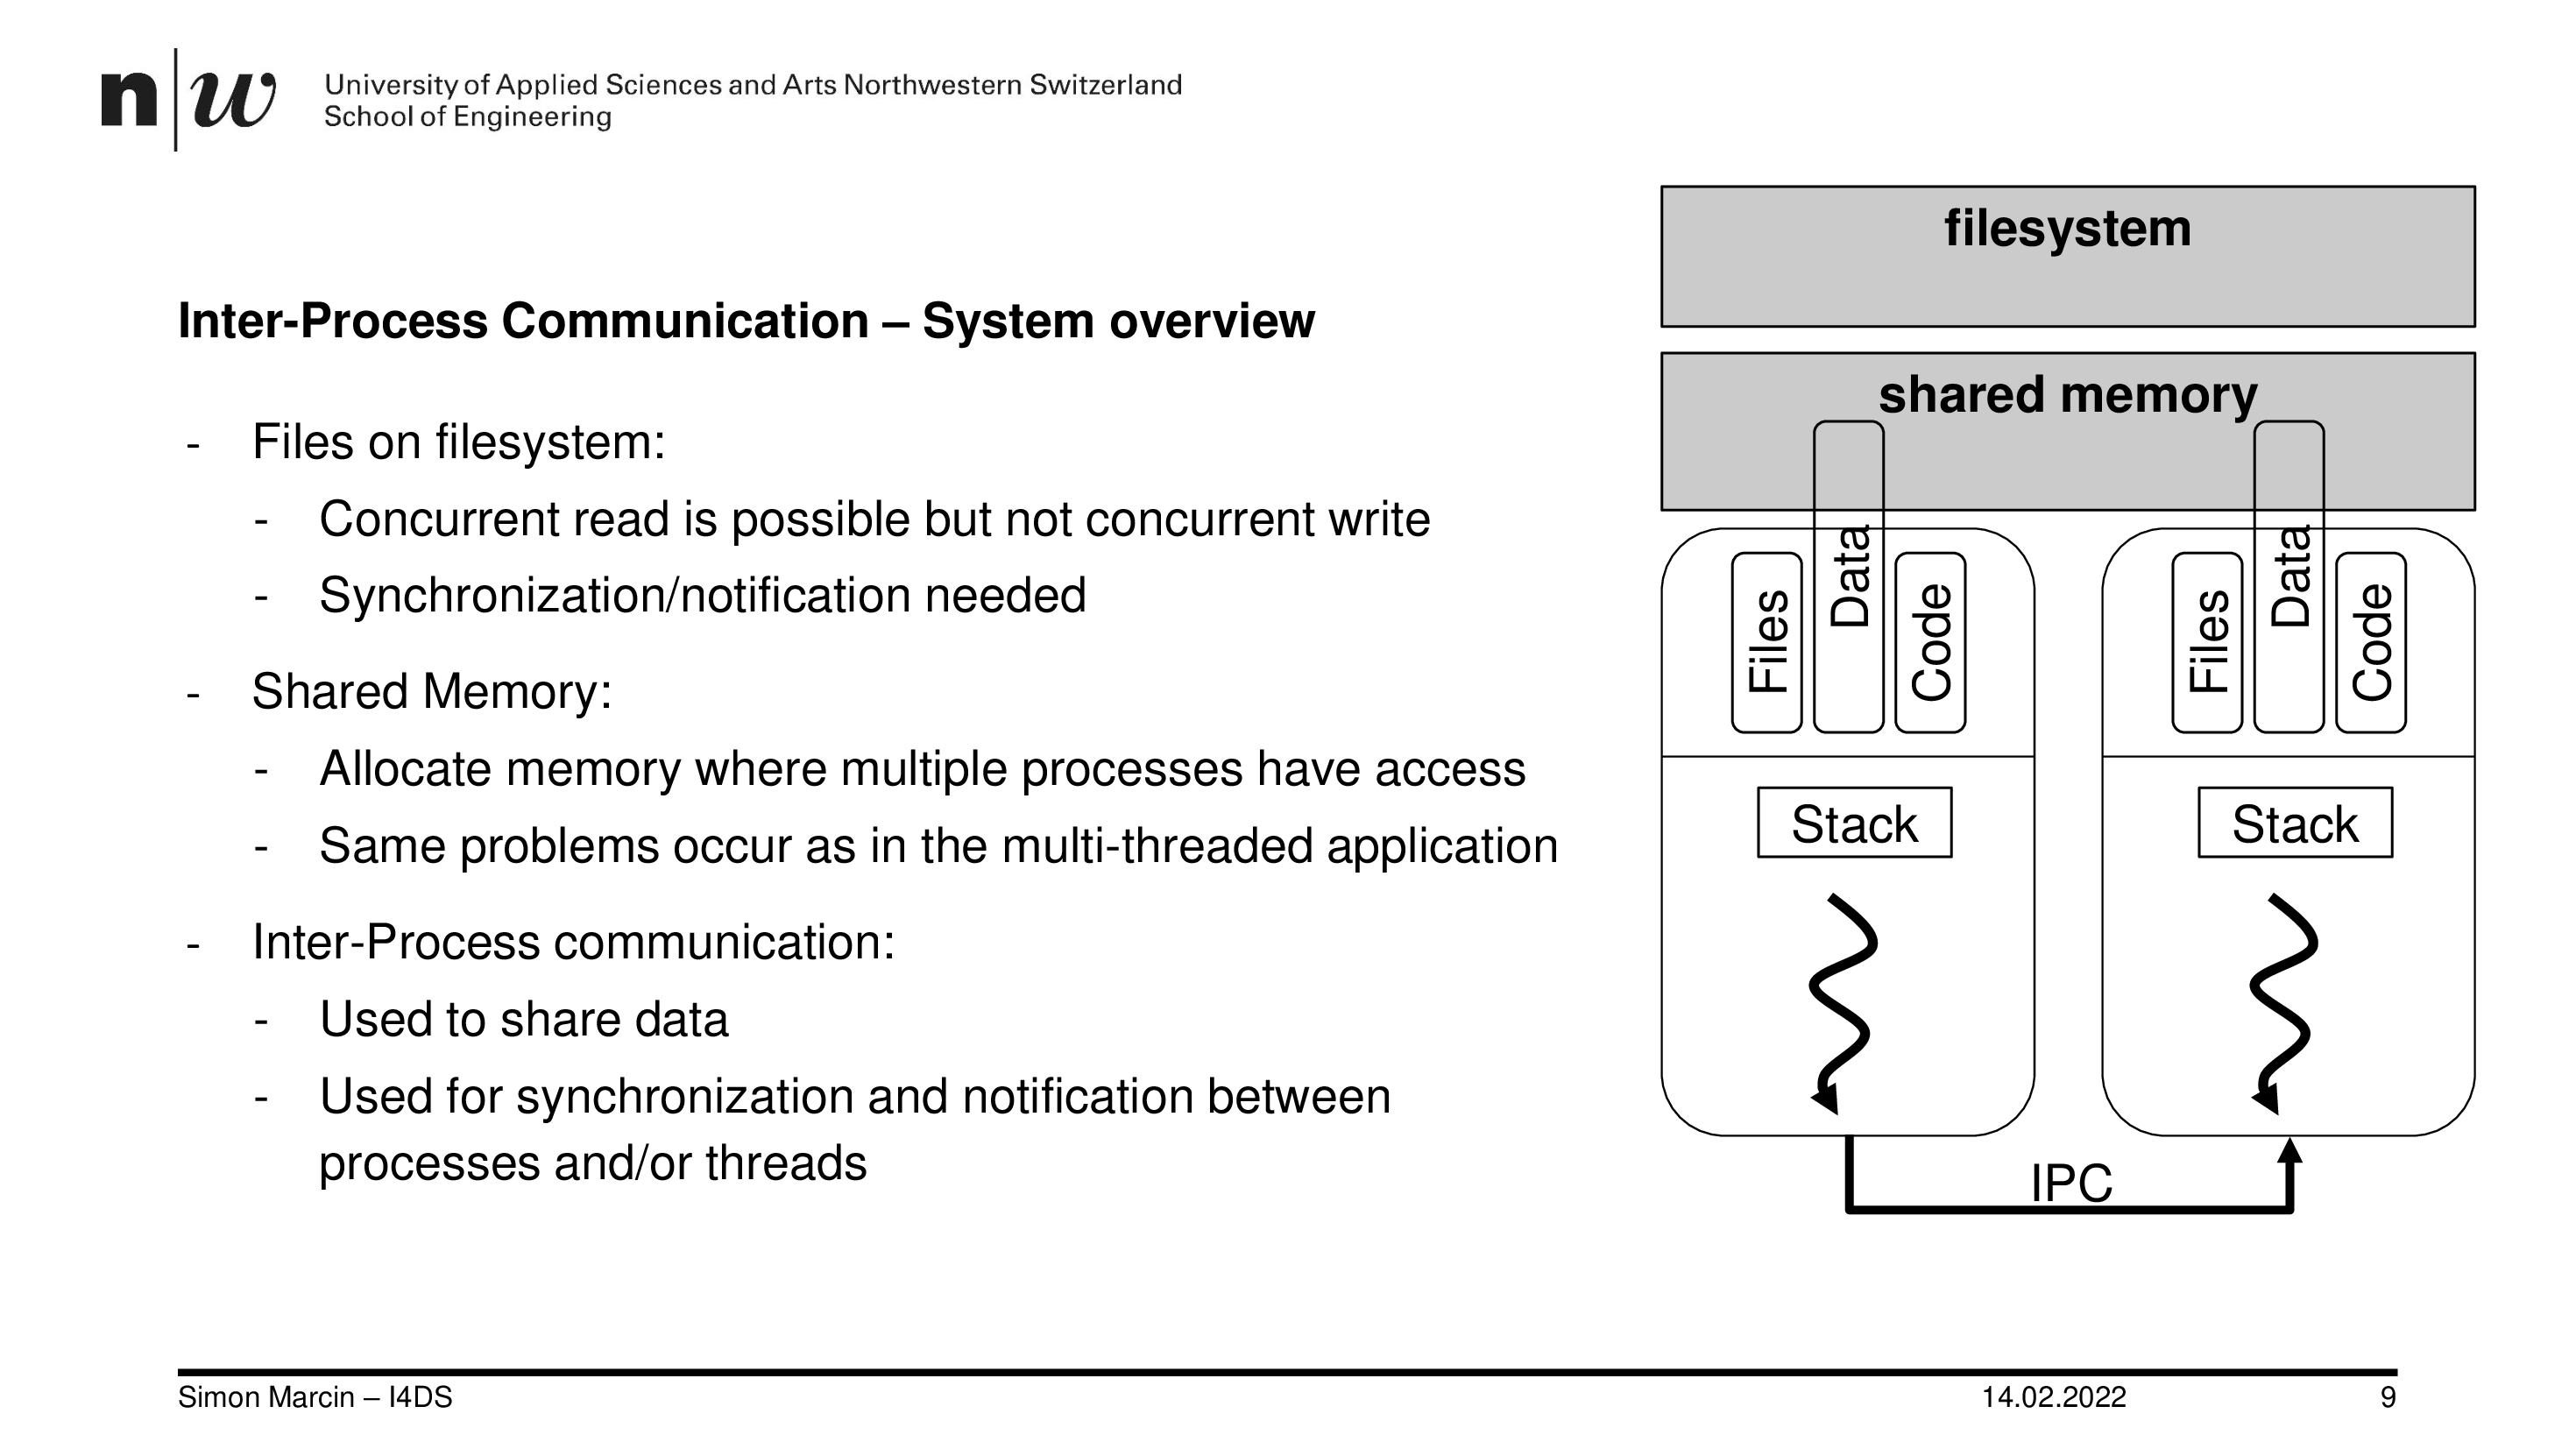

In [9]:
WImage(filename="01_IPC.pdf[8]", resolution=200)

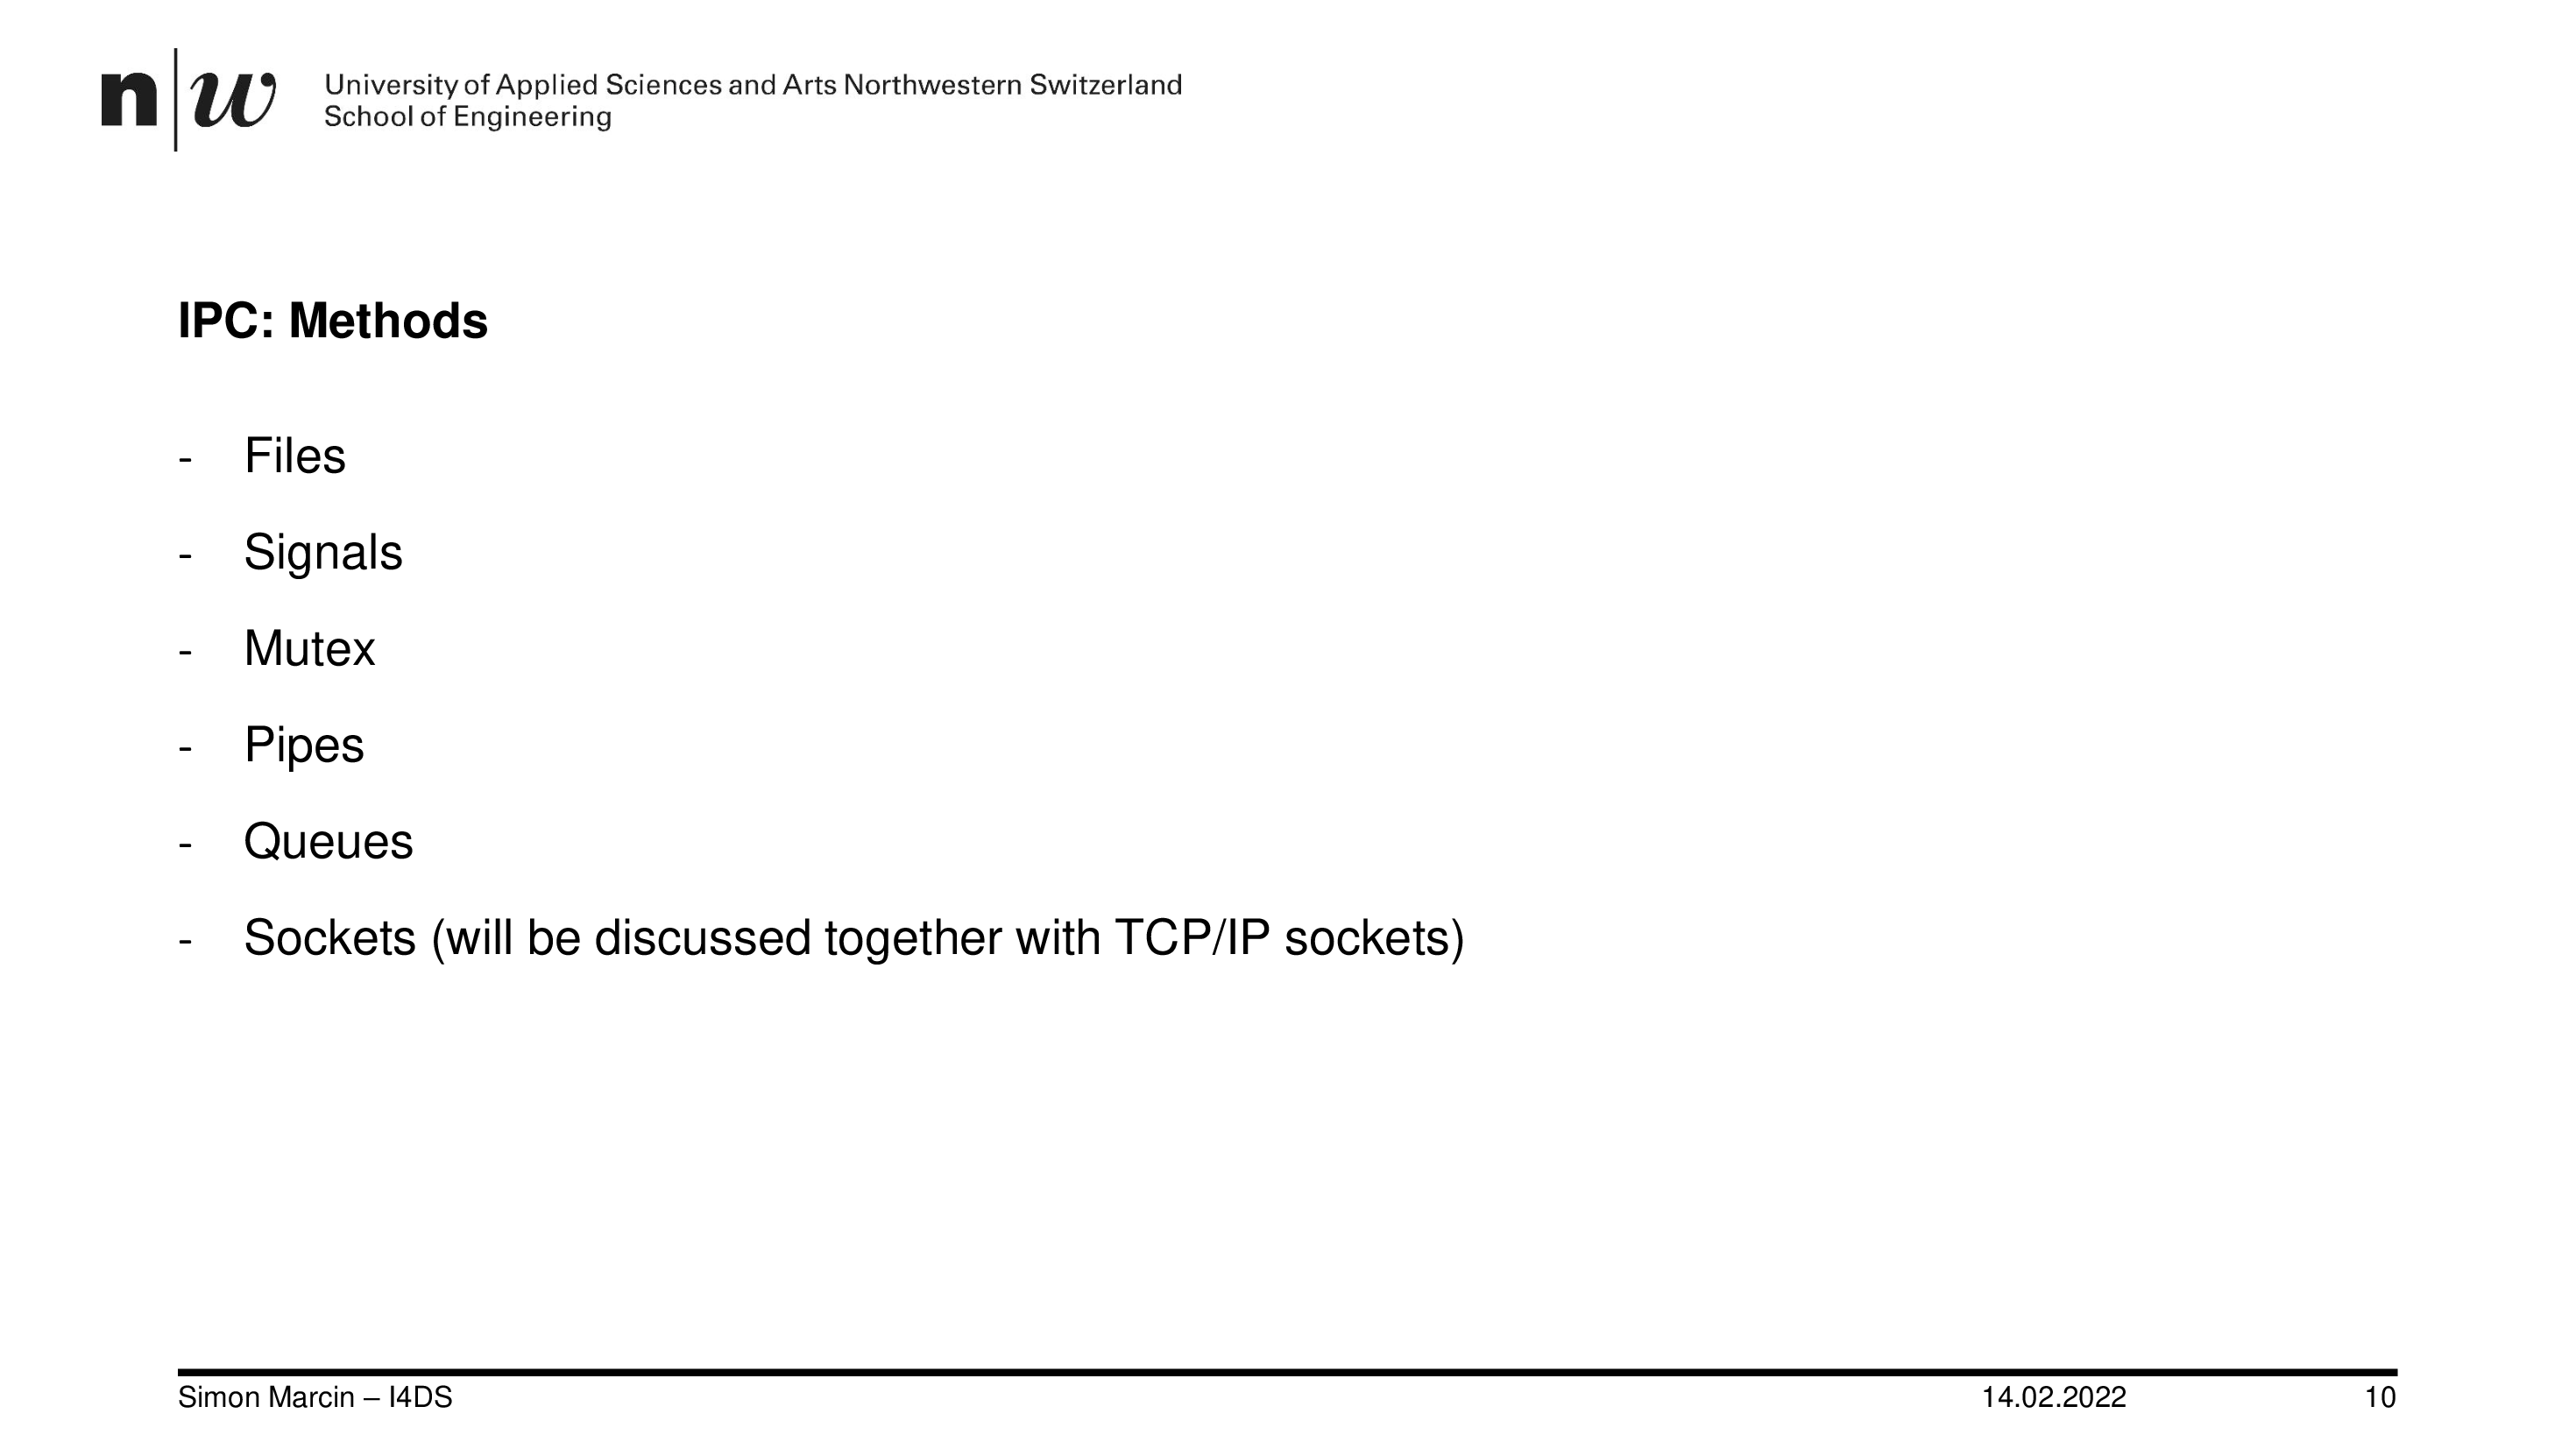

In [10]:
WImage(filename="01_IPC.pdf[9]", resolution=200)

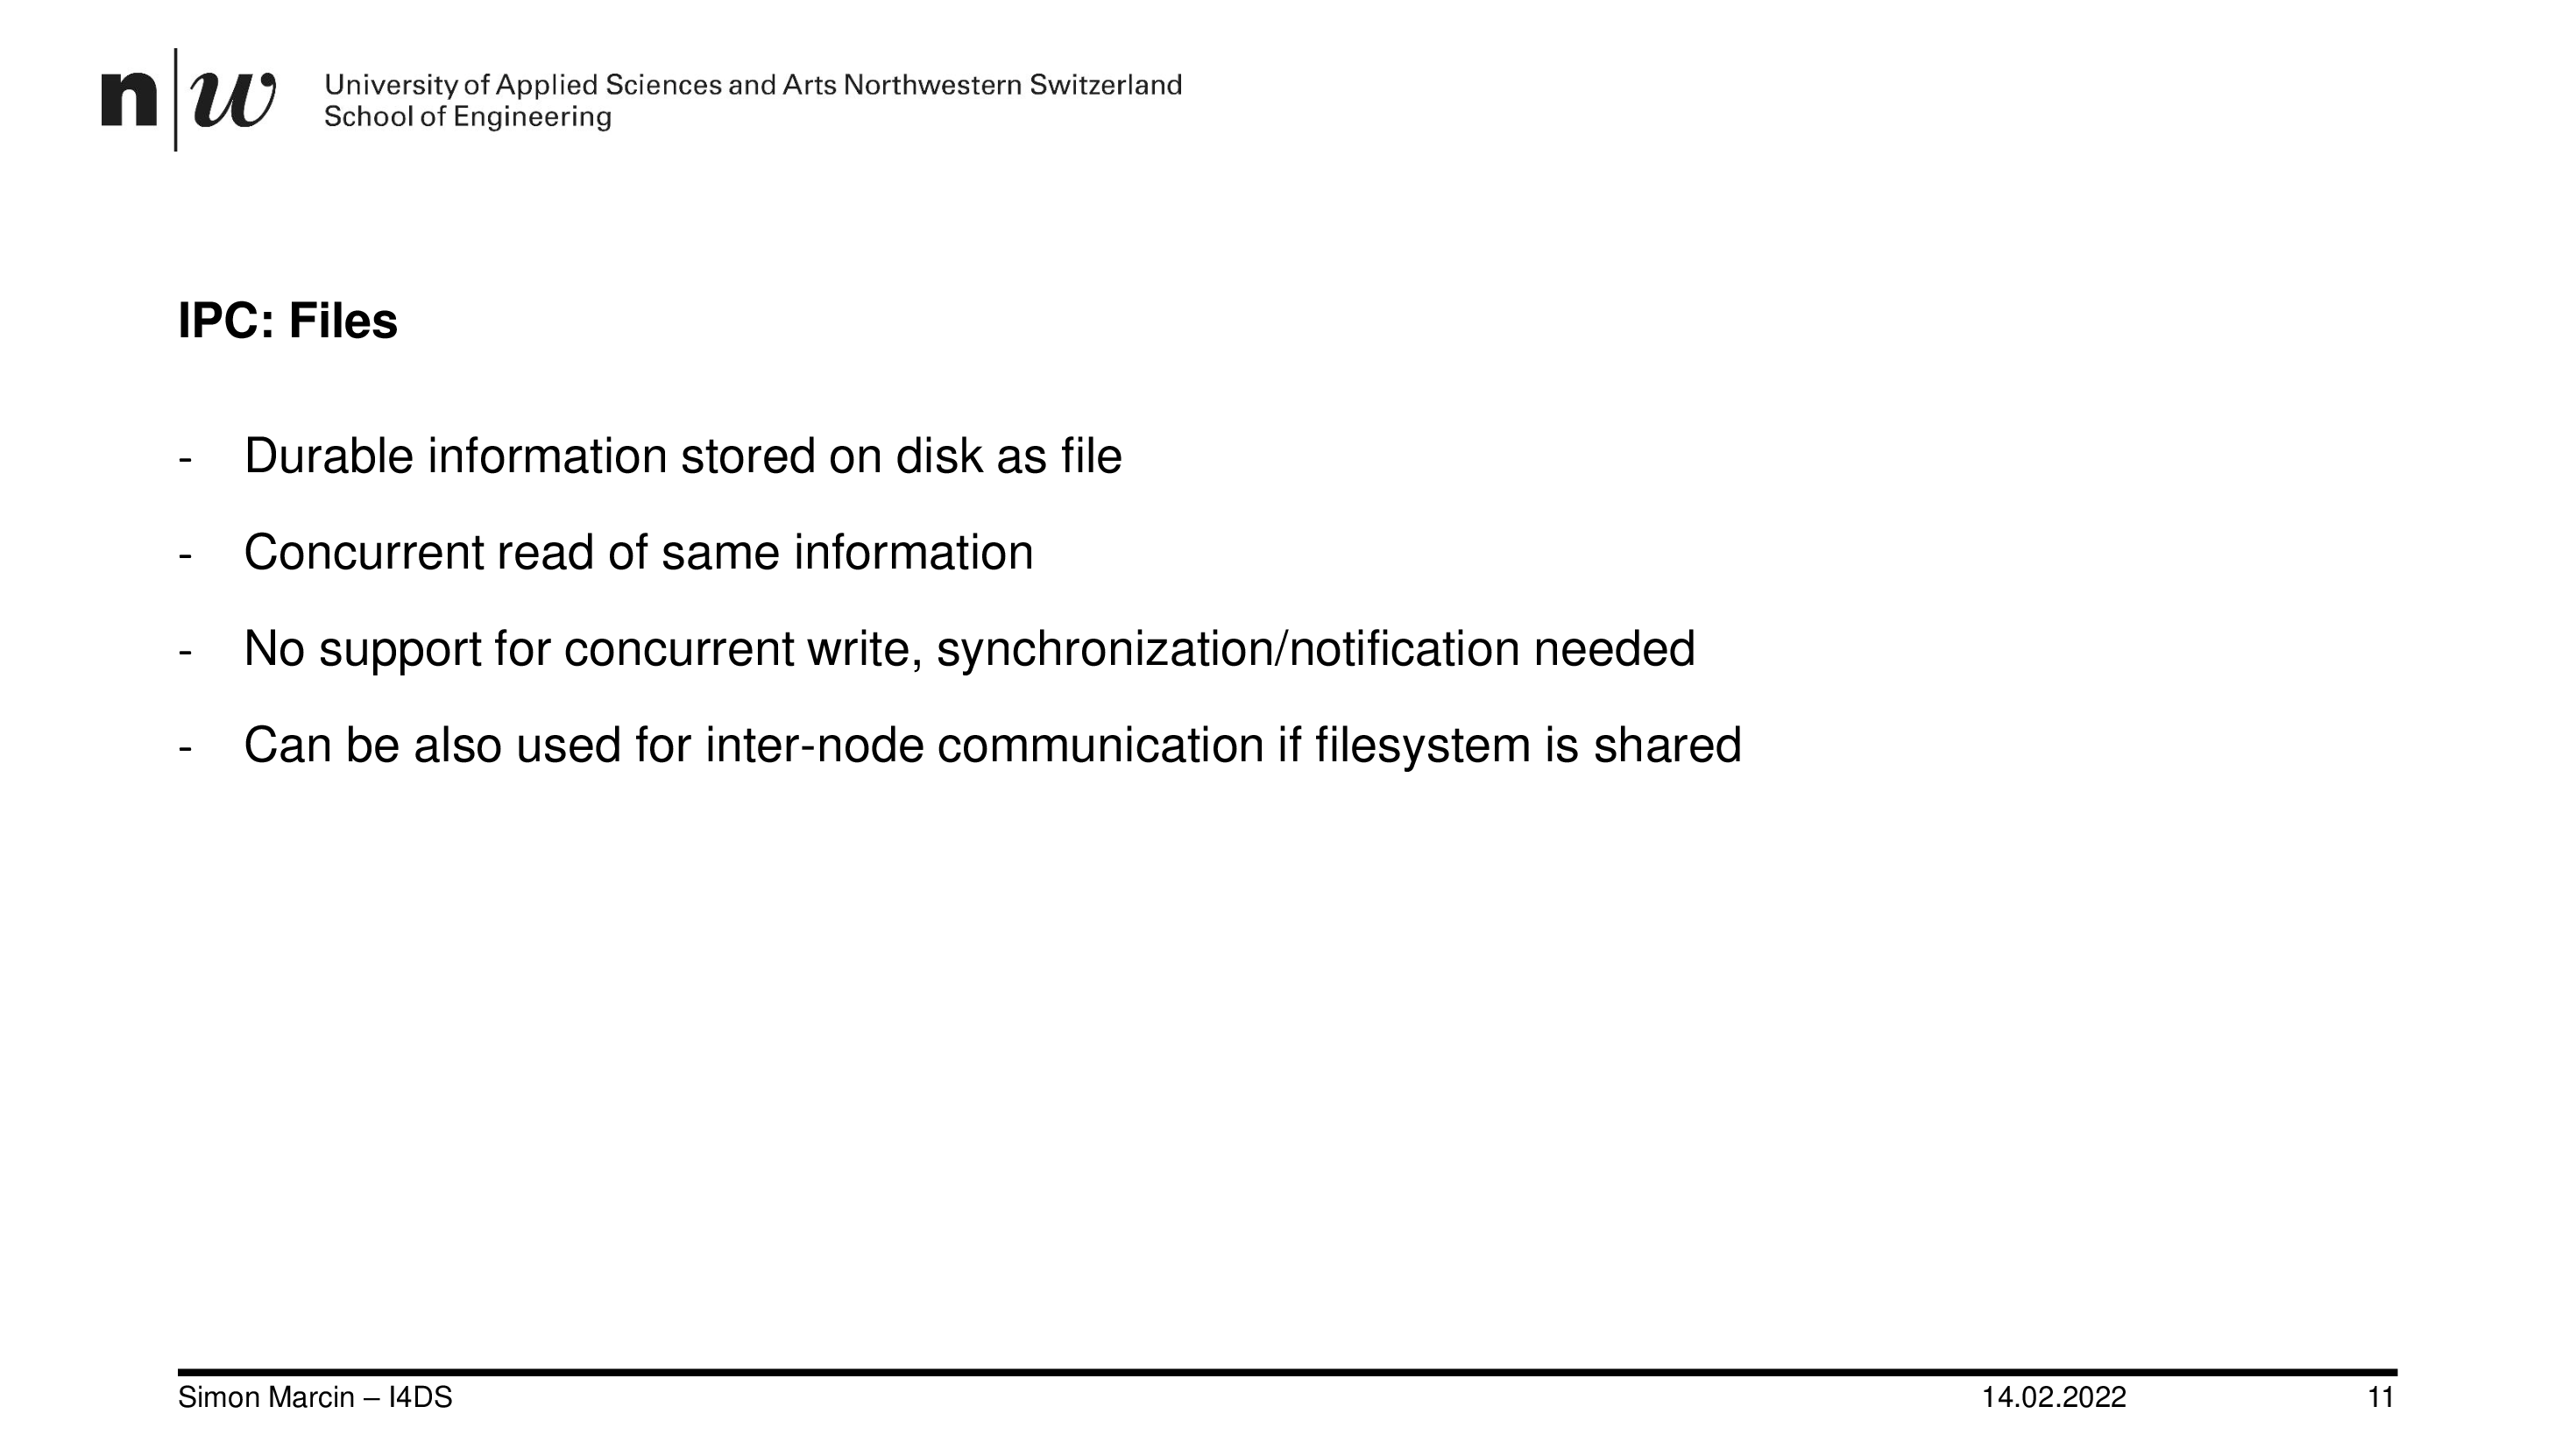

In [11]:
WImage(filename="01_IPC.pdf[10]", resolution=200)

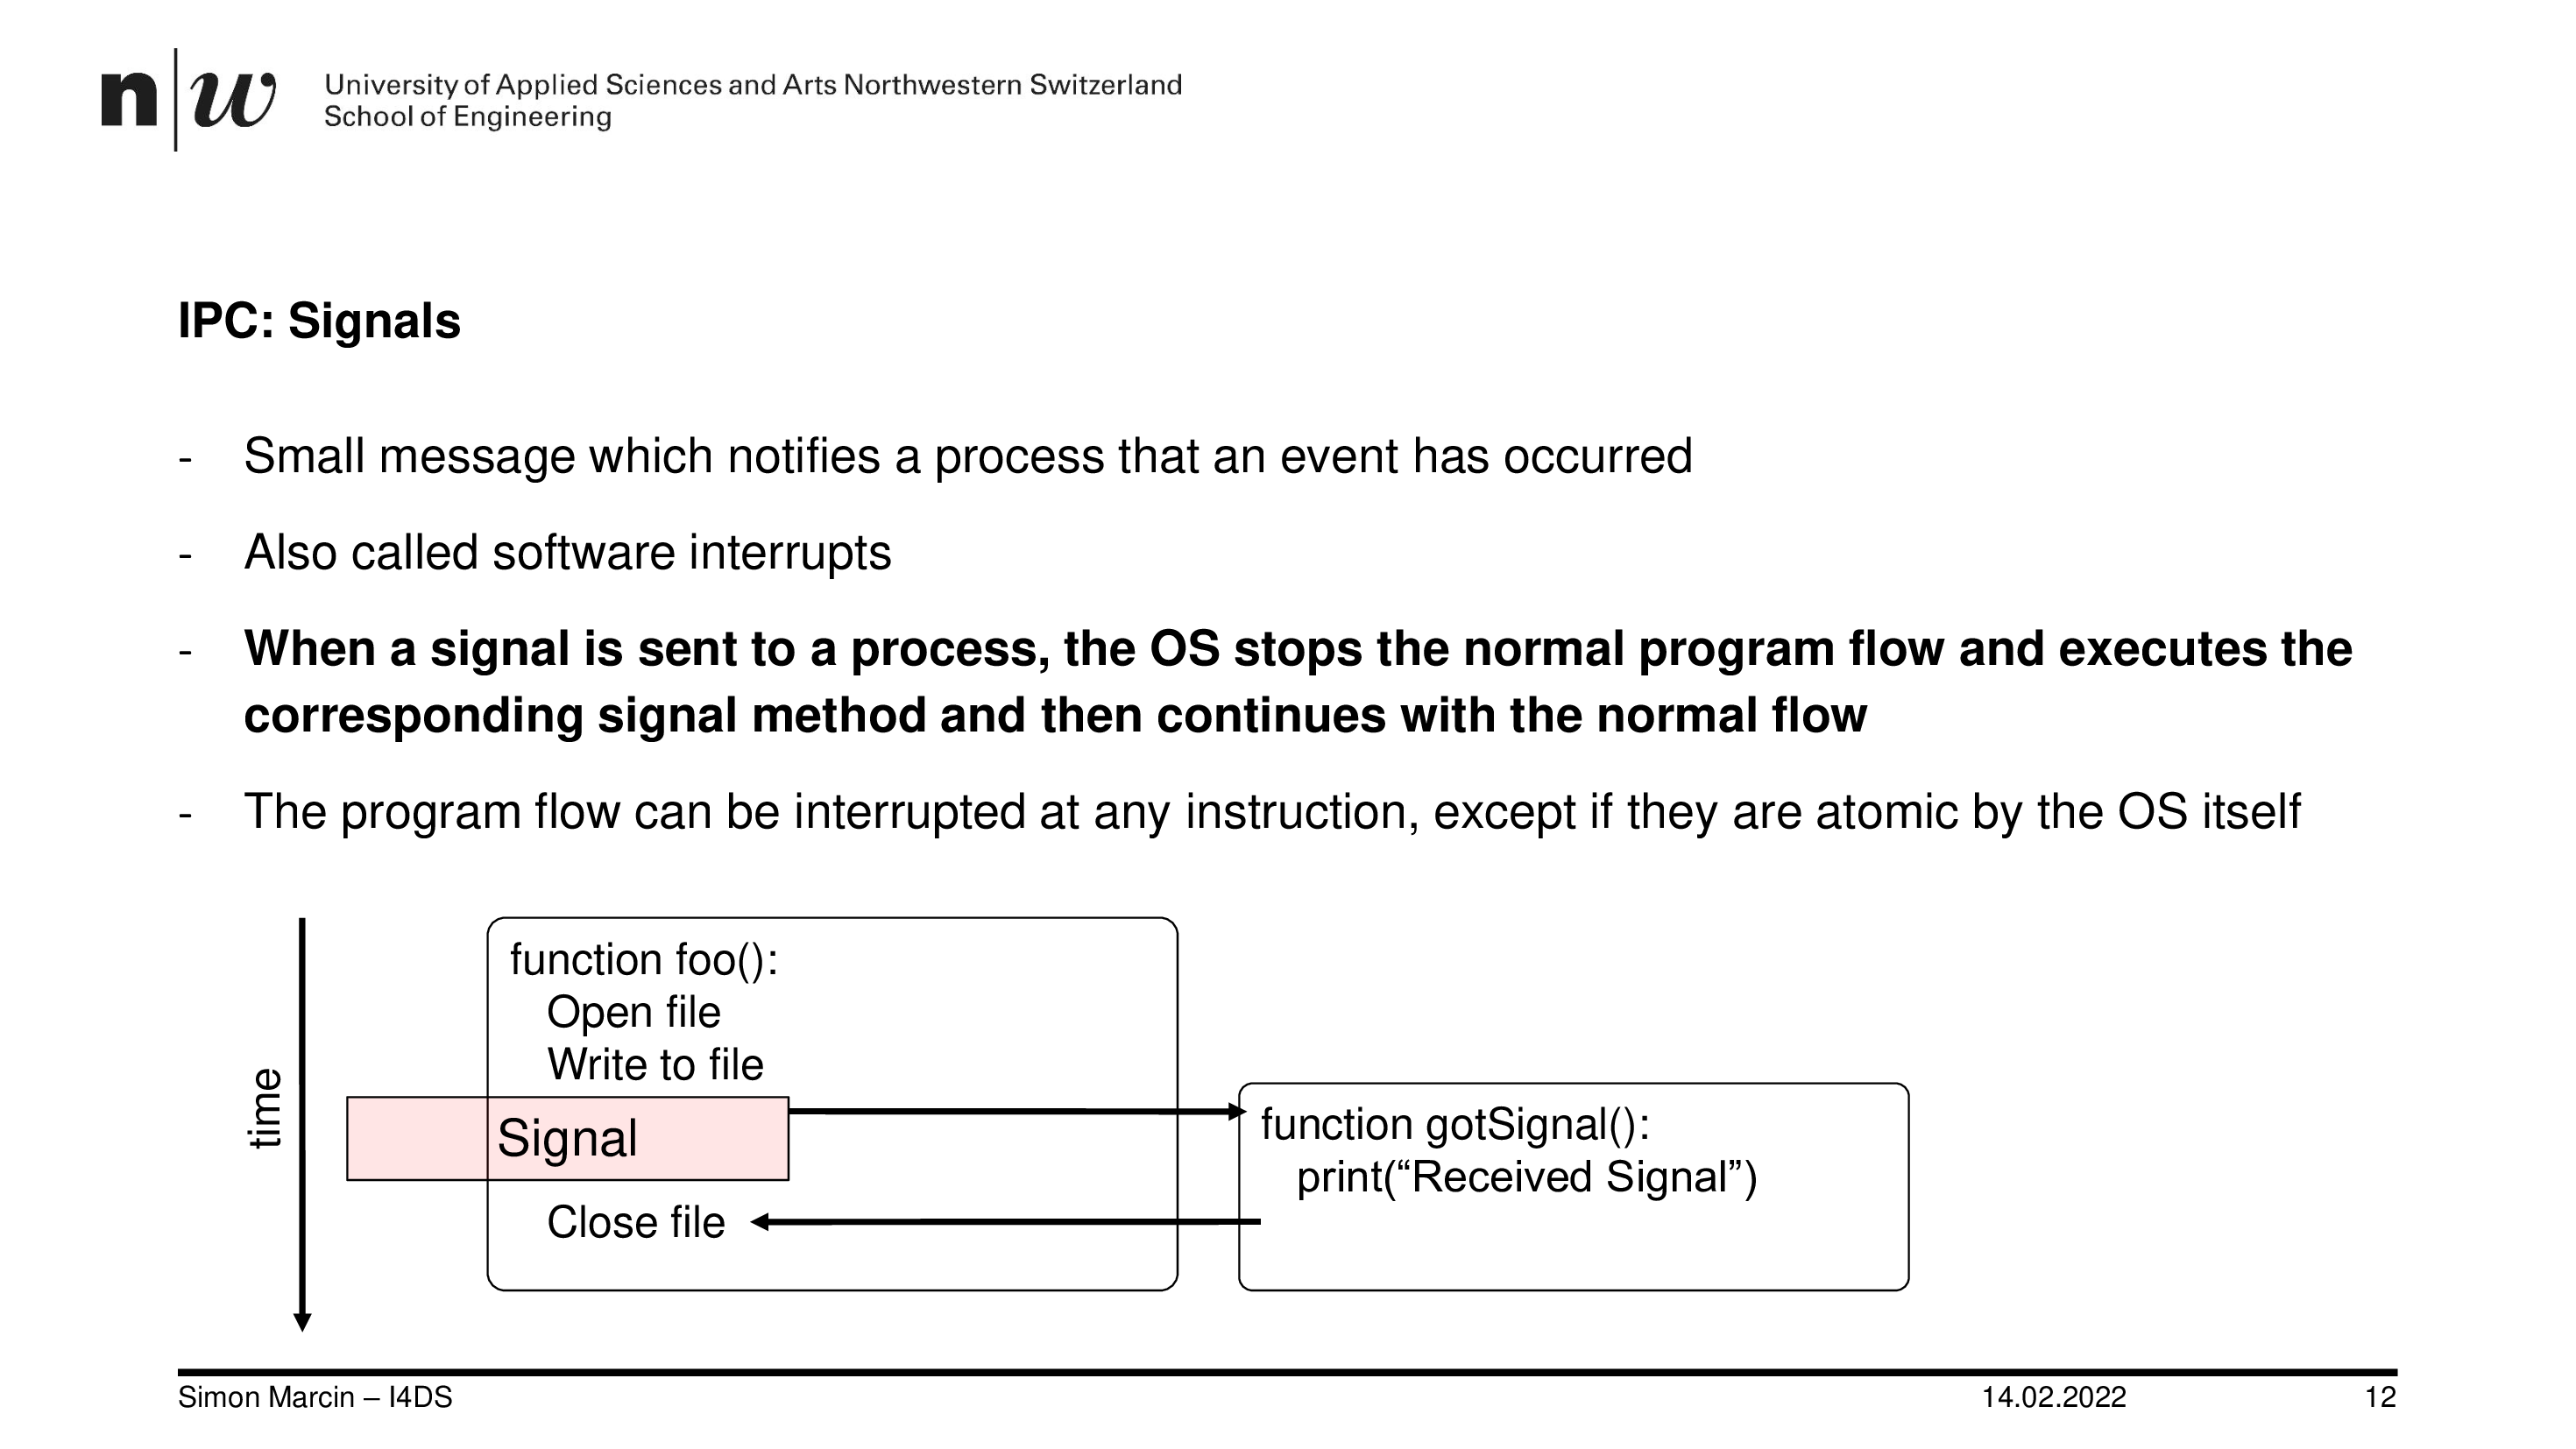

In [12]:
WImage(filename="01_IPC.pdf[11]", resolution=200)

#### Signals
Signals are mostly sent from the OS to the processes to stop/continue them or to kill them (in most cases). But they are also used in IPC to notify processes about some events. The following code uses the signal handler module to catch the signals (red section in the slide) and execute an user defined function ("gotSignal" in the Slides). To get a brief overview of the signal numbers, checkout https://de.wikipedia.org/wiki/Signal_(Unix)#G%C3%A4ngige_UNIX-Signale and refer to column C (x86).

In [26]:
#import the needed modules
import signal
import os
import time

exit_flag = False

#End the process by setting the for loop to False
def exit_with_style(signum, frame):
    global exit_flag
    print(f"Adios!")
    exit_flag = True

#Don't end the process
def do_not_exit(signum, frame):
    print(f"I received signal {signum} - but I do nothing with it.")
    
#Handle signal number 10 (user specific)
signal.signal(10, exit_with_style)
#Handle signal number 15 (SIG_TERM, regular kill signal)
signal.signal(15, do_not_exit)


while not exit_flag:
    print(f"I'm still here and have pid {os.getpid()}.")
    time.sleep(4)

I'm still here and have pid 106946.
I'm still here and have pid 106946.
I received signal 15 - but I do nothing with it.
I'm still here and have pid 106946.
I'm still here and have pid 106946.
Adios!


Use the the Linux Terminal and the `kill` command to send signals to your process. `kill` sends a signal (default 15 - SIG_TERM) to a process ID. But kill can be used to send any signal number to a process. Try to stop the process with different signals (you have to open a dedicated terminal and send the `kill` command from there.):

`kill pid`

`kill -10 pid`

**ToDo**: Can you adapt the code to catch the Stop-Icon signal?

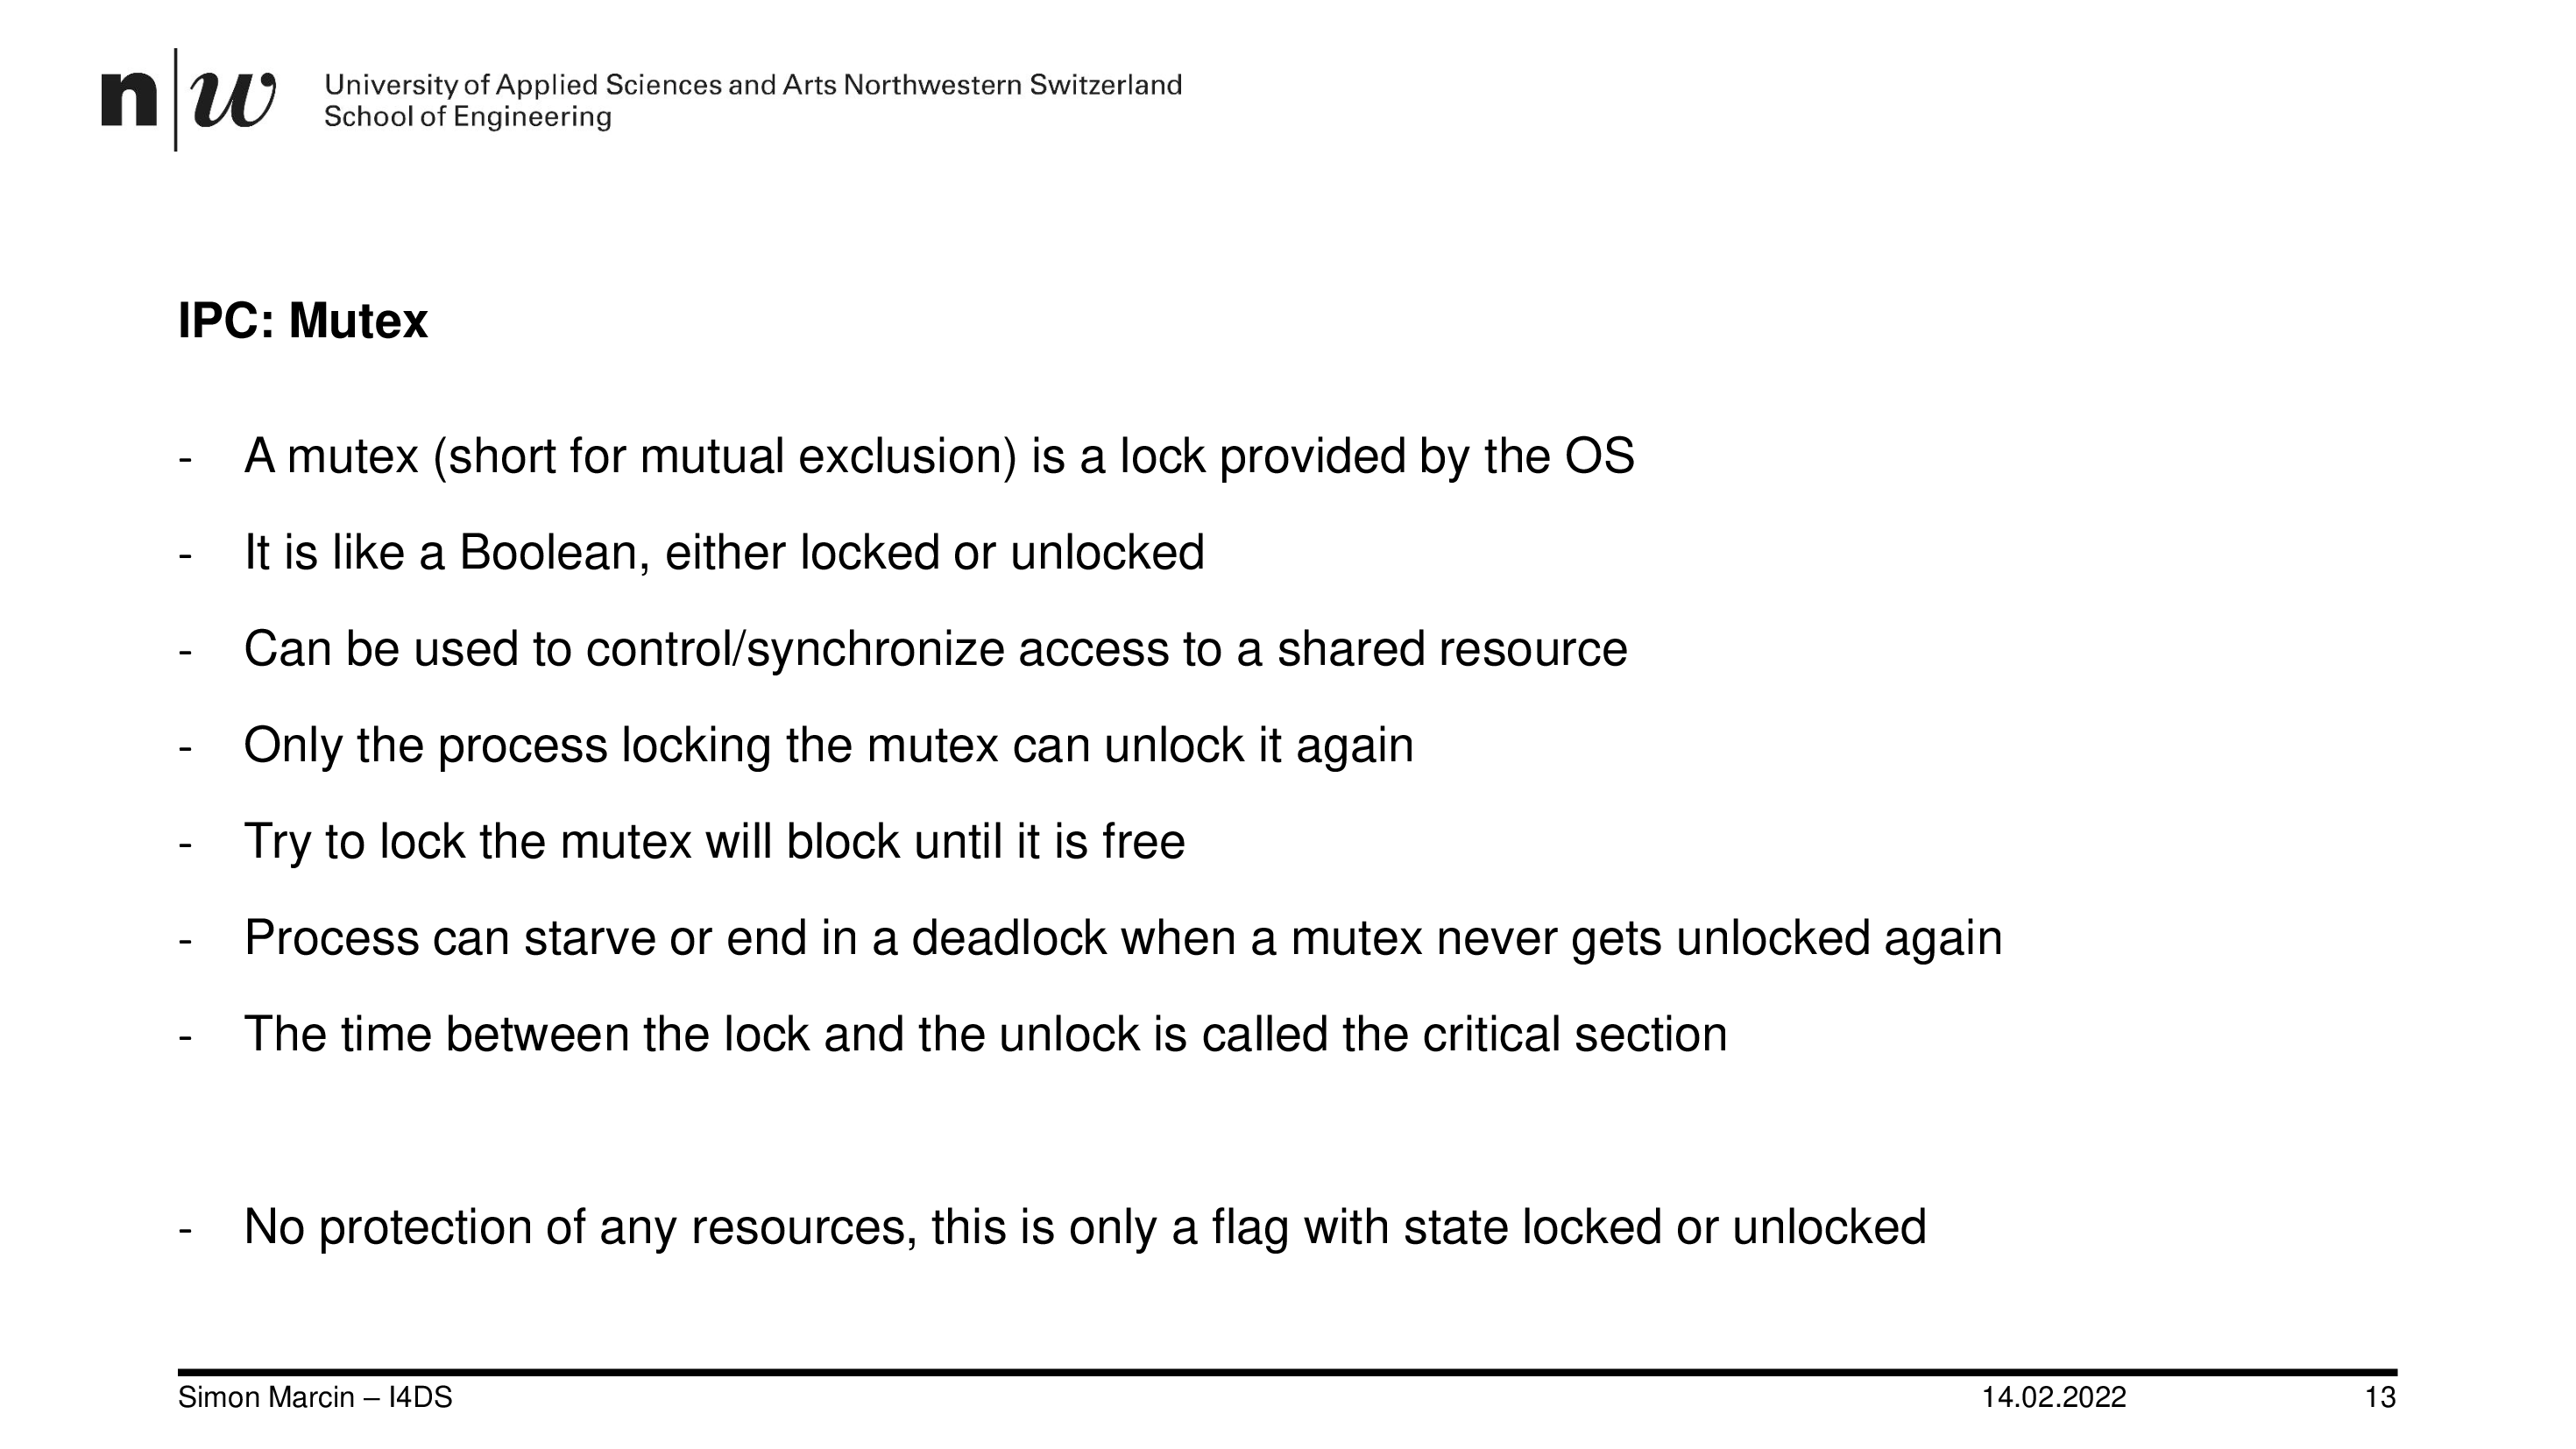

In [13]:
WImage(filename="01_IPC.pdf[12]", resolution=200)

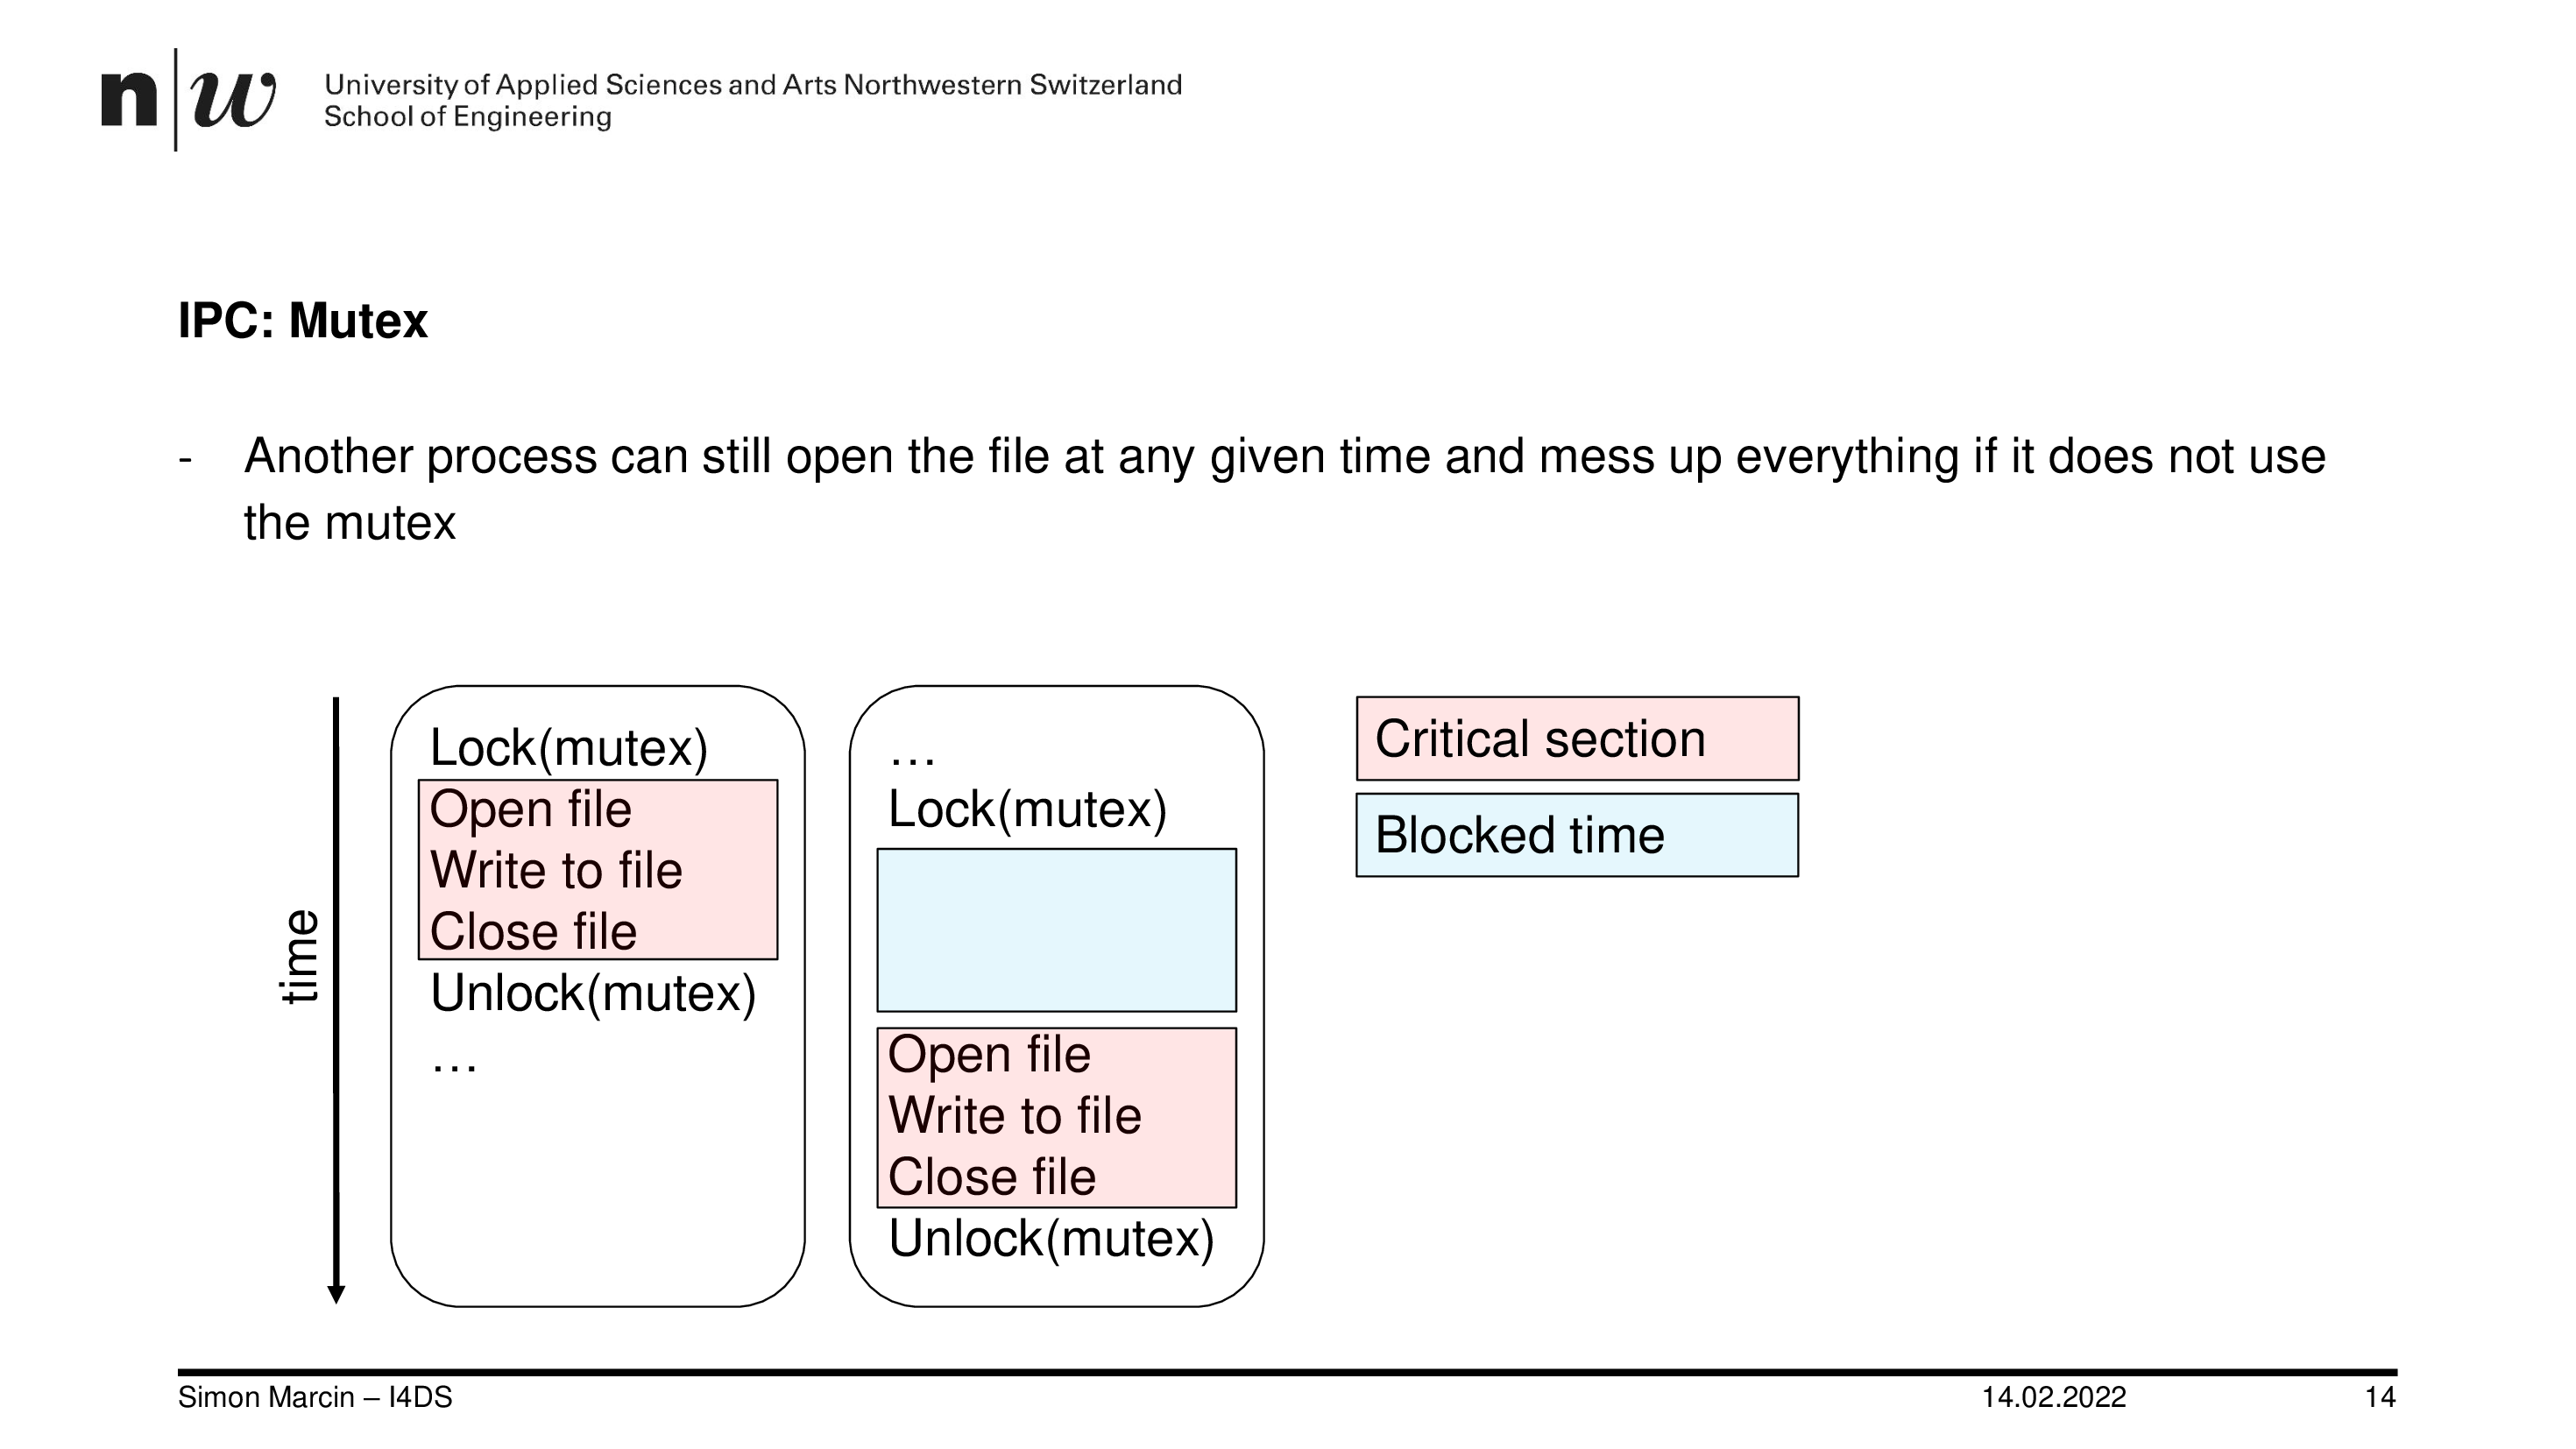

In [14]:
WImage(filename="01_IPC.pdf[13]", resolution=200)

#### Mutex
The Mutex lock is used to protect a critical section of the code which only one thread/process should execute simultaneously. The next function will print some lines which should stay together, first without a Mutex and later with a Mutex.

In [29]:
#This is a helper function to start and close multiple processes
import multiprocessing
def helper_start_n_processes(n_procs, target, args=()):
    """
    n_procs: number of processes to start.
    target:  the function which gets executed n_procs times
    args:    tuple with all arguments to target function - has to be a tuple, even in case of one argument
    """
    procs = []
    # Open n_procs new processes and execute target function
    for i in range(n_procs):
        p = multiprocessing.Process(target=target, args=args)
        p.start()
        procs.append(p)
    # Properly close threads again
    for i in range(n_procs):
        procs[i].join()

In [31]:
def poem():
    print(f"Roses are red,")
    print(f"dirt is brown.")
    print(f"Users lose their minds")
    print(f"when the Wi-Fi goes down.")
    print()
    
helper_start_n_processes(3, poem)

Roses are red,
dirt is brown.
Users lose their minds
when the Wi-Fi goes down.

Roses are red,
dirt is brown.
Users lose their minds
Roses are red,
when the Wi-Fi goes down.
dirt is brown.

Users lose their minds
when the Wi-Fi goes down.



In [32]:
def poem_with_mutex(mutex):
    mutex.acquire()
    poem()
    mutex.release()

lock = multiprocessing.Lock()
helper_start_n_processes(3, poem_with_mutex, args=(lock,))

Roses are red,
dirt is brown.
Users lose their minds
when the Wi-Fi goes down.

Roses are red,
dirt is brown.
Users lose their minds
when the Wi-Fi goes down.

Roses are red,
dirt is brown.
Users lose their minds
when the Wi-Fi goes down.



**ToDo:** Try to deadlock the code by applying the Mutex not properly. Furthermore, try to start a process (or processes) which use the poem function while others use the poem_with_mutex function.

Hint: `if os.getpid() % 2 == 0:` divide the processes into two groups, one has even proc numbers the other group has odd proc numbers.

In [33]:
#ToDo: Implement a deadlock.


In [34]:
#ToDo: Implement a process which does not use the Mutex while others do. 


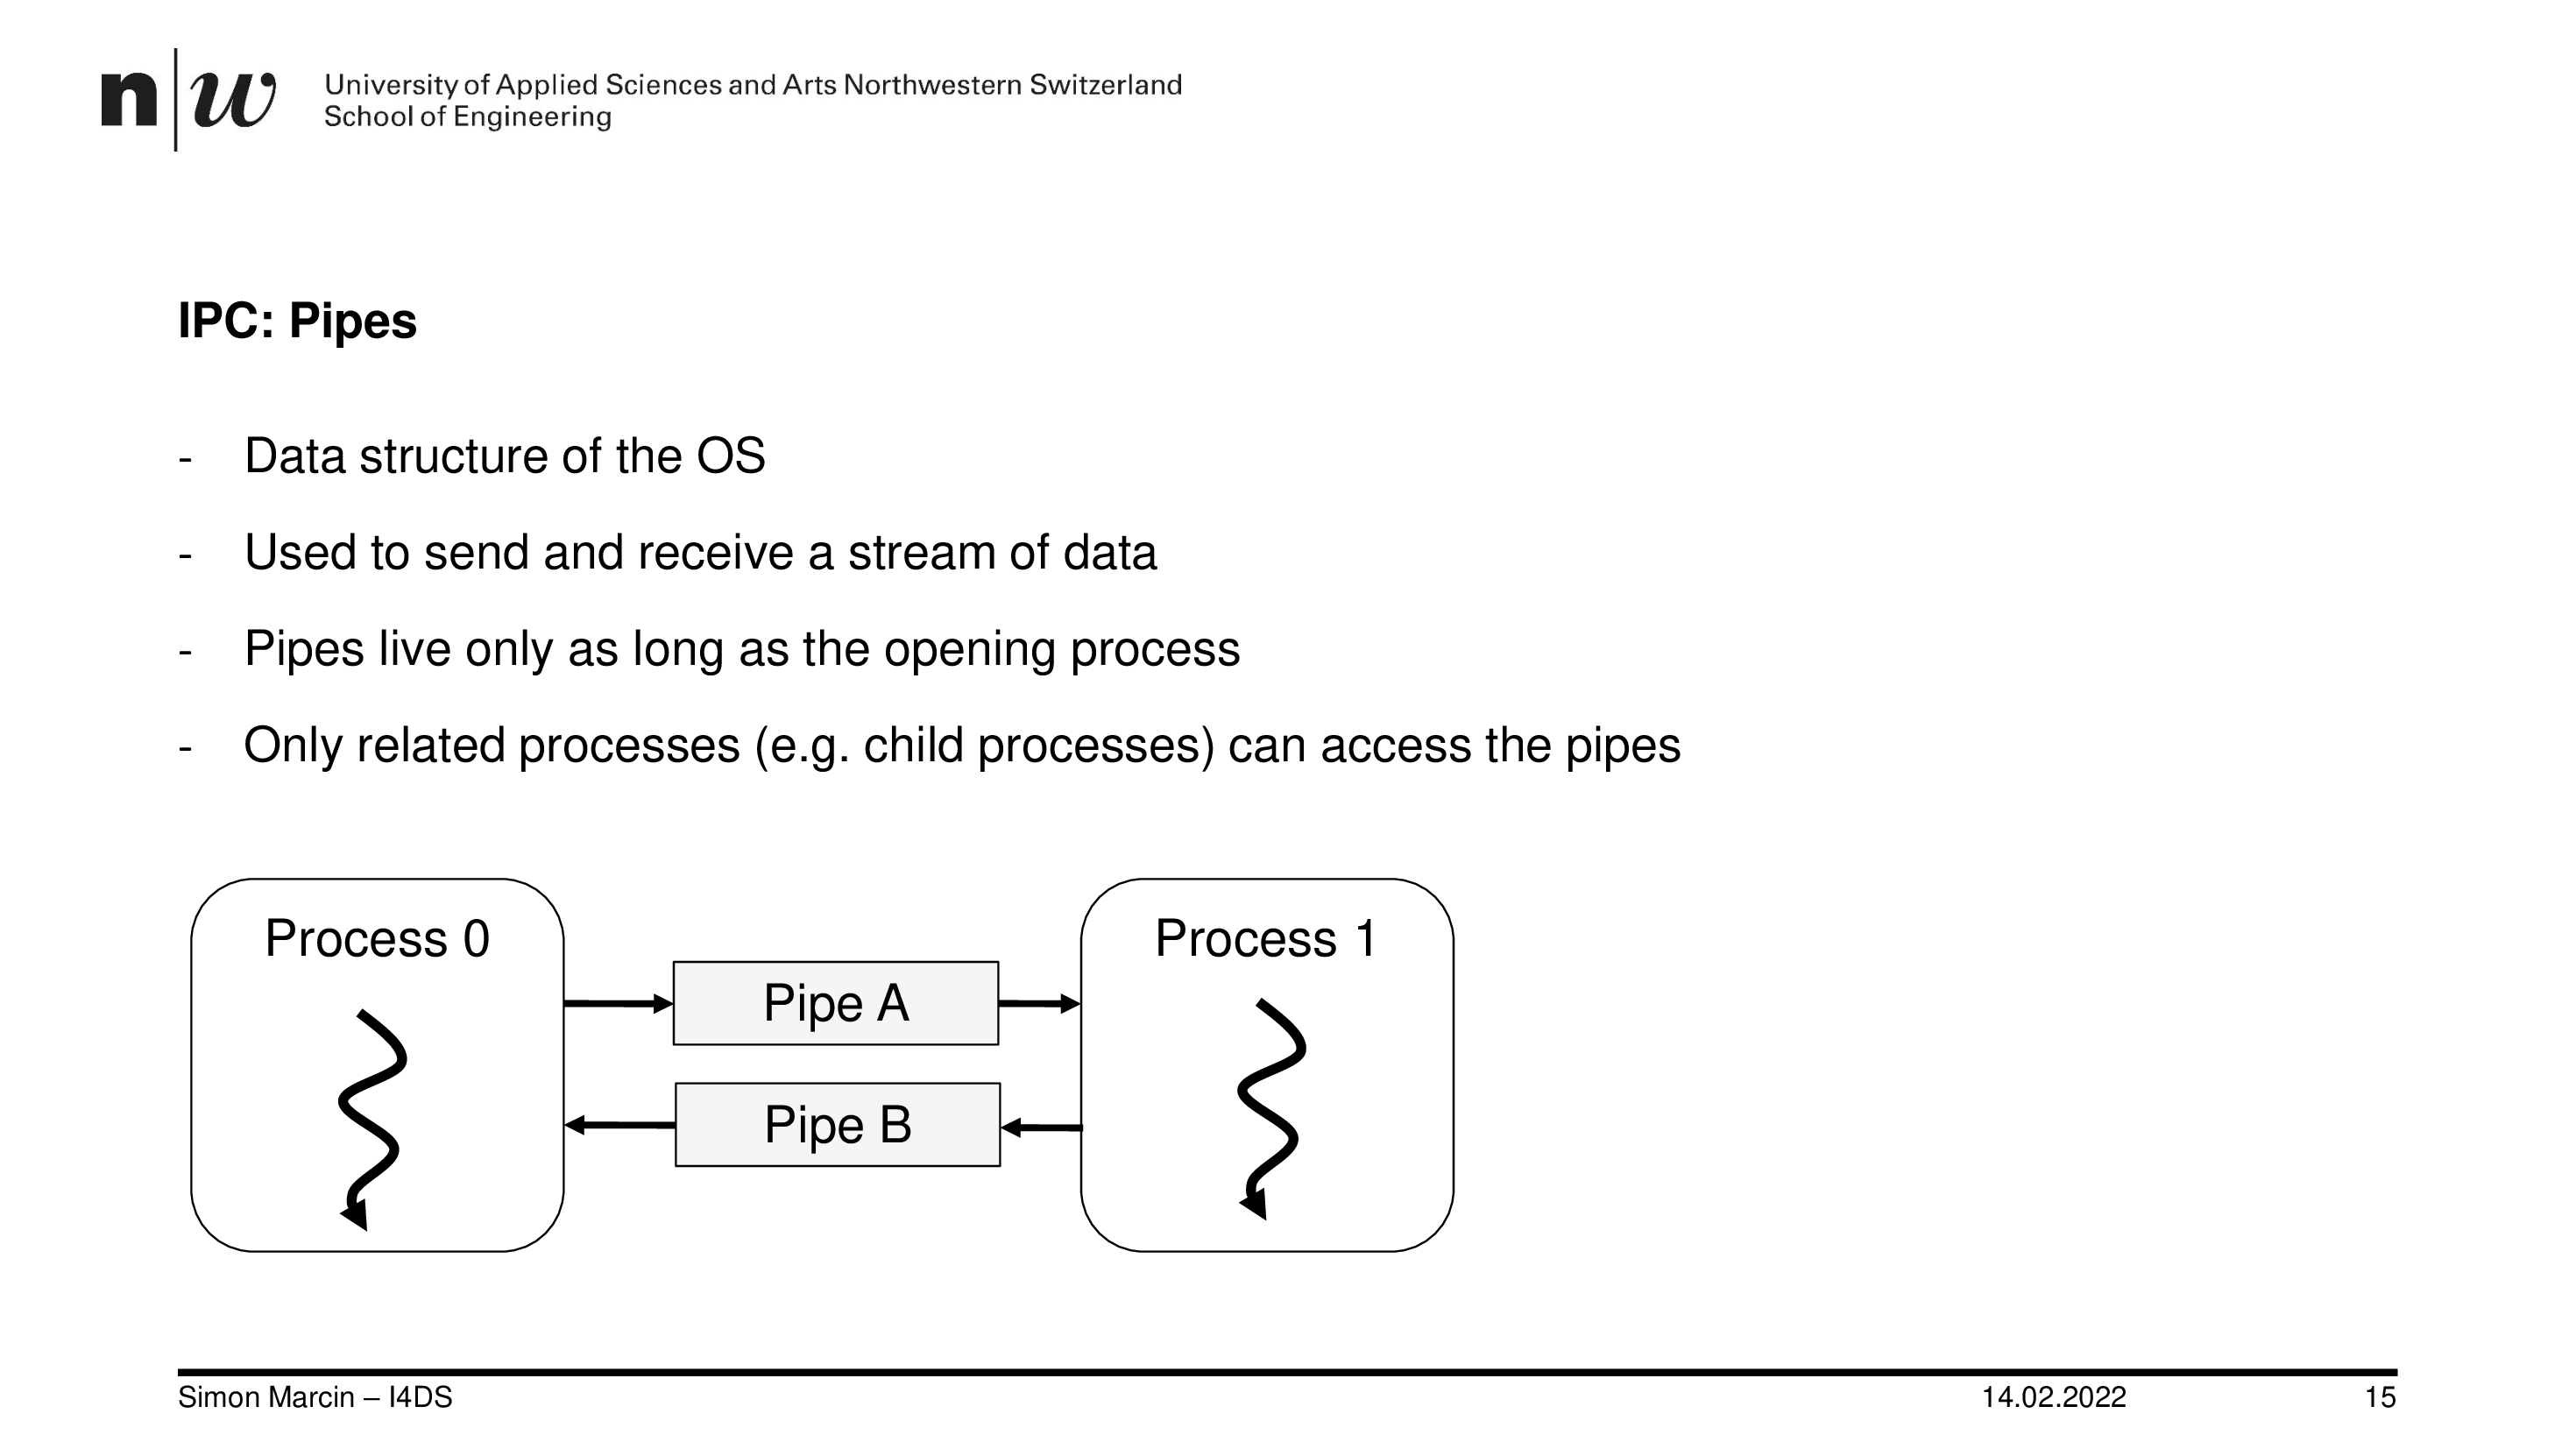

In [15]:
WImage(filename="01_IPC.pdf[14]", resolution=200)

#### Pipes
Pipes are used to send a stream of data from one process to another. The simplest use case is sending the output (stdout) of a process to the input of another. This can be done on the Terminal itself. The pipe operator (|) does exactly this. Lets pipe following Linux commands together:
- ls: list content of a directory
- head -n: Show only the first n entries
- tail -n: Show only the last n entries

In [38]:
%%bash
ls /home/$USER

00_Intro
01_IPC
02_IP
03_TCP
04_UDP
05_Troubleshooting
06_Assessment


In [39]:
%%bash
ls /home/$USER | head -2

00_Intro
01_IPC


In [40]:
%%bash
ls /home/$USER | head -2 | tail -1

01_IPC


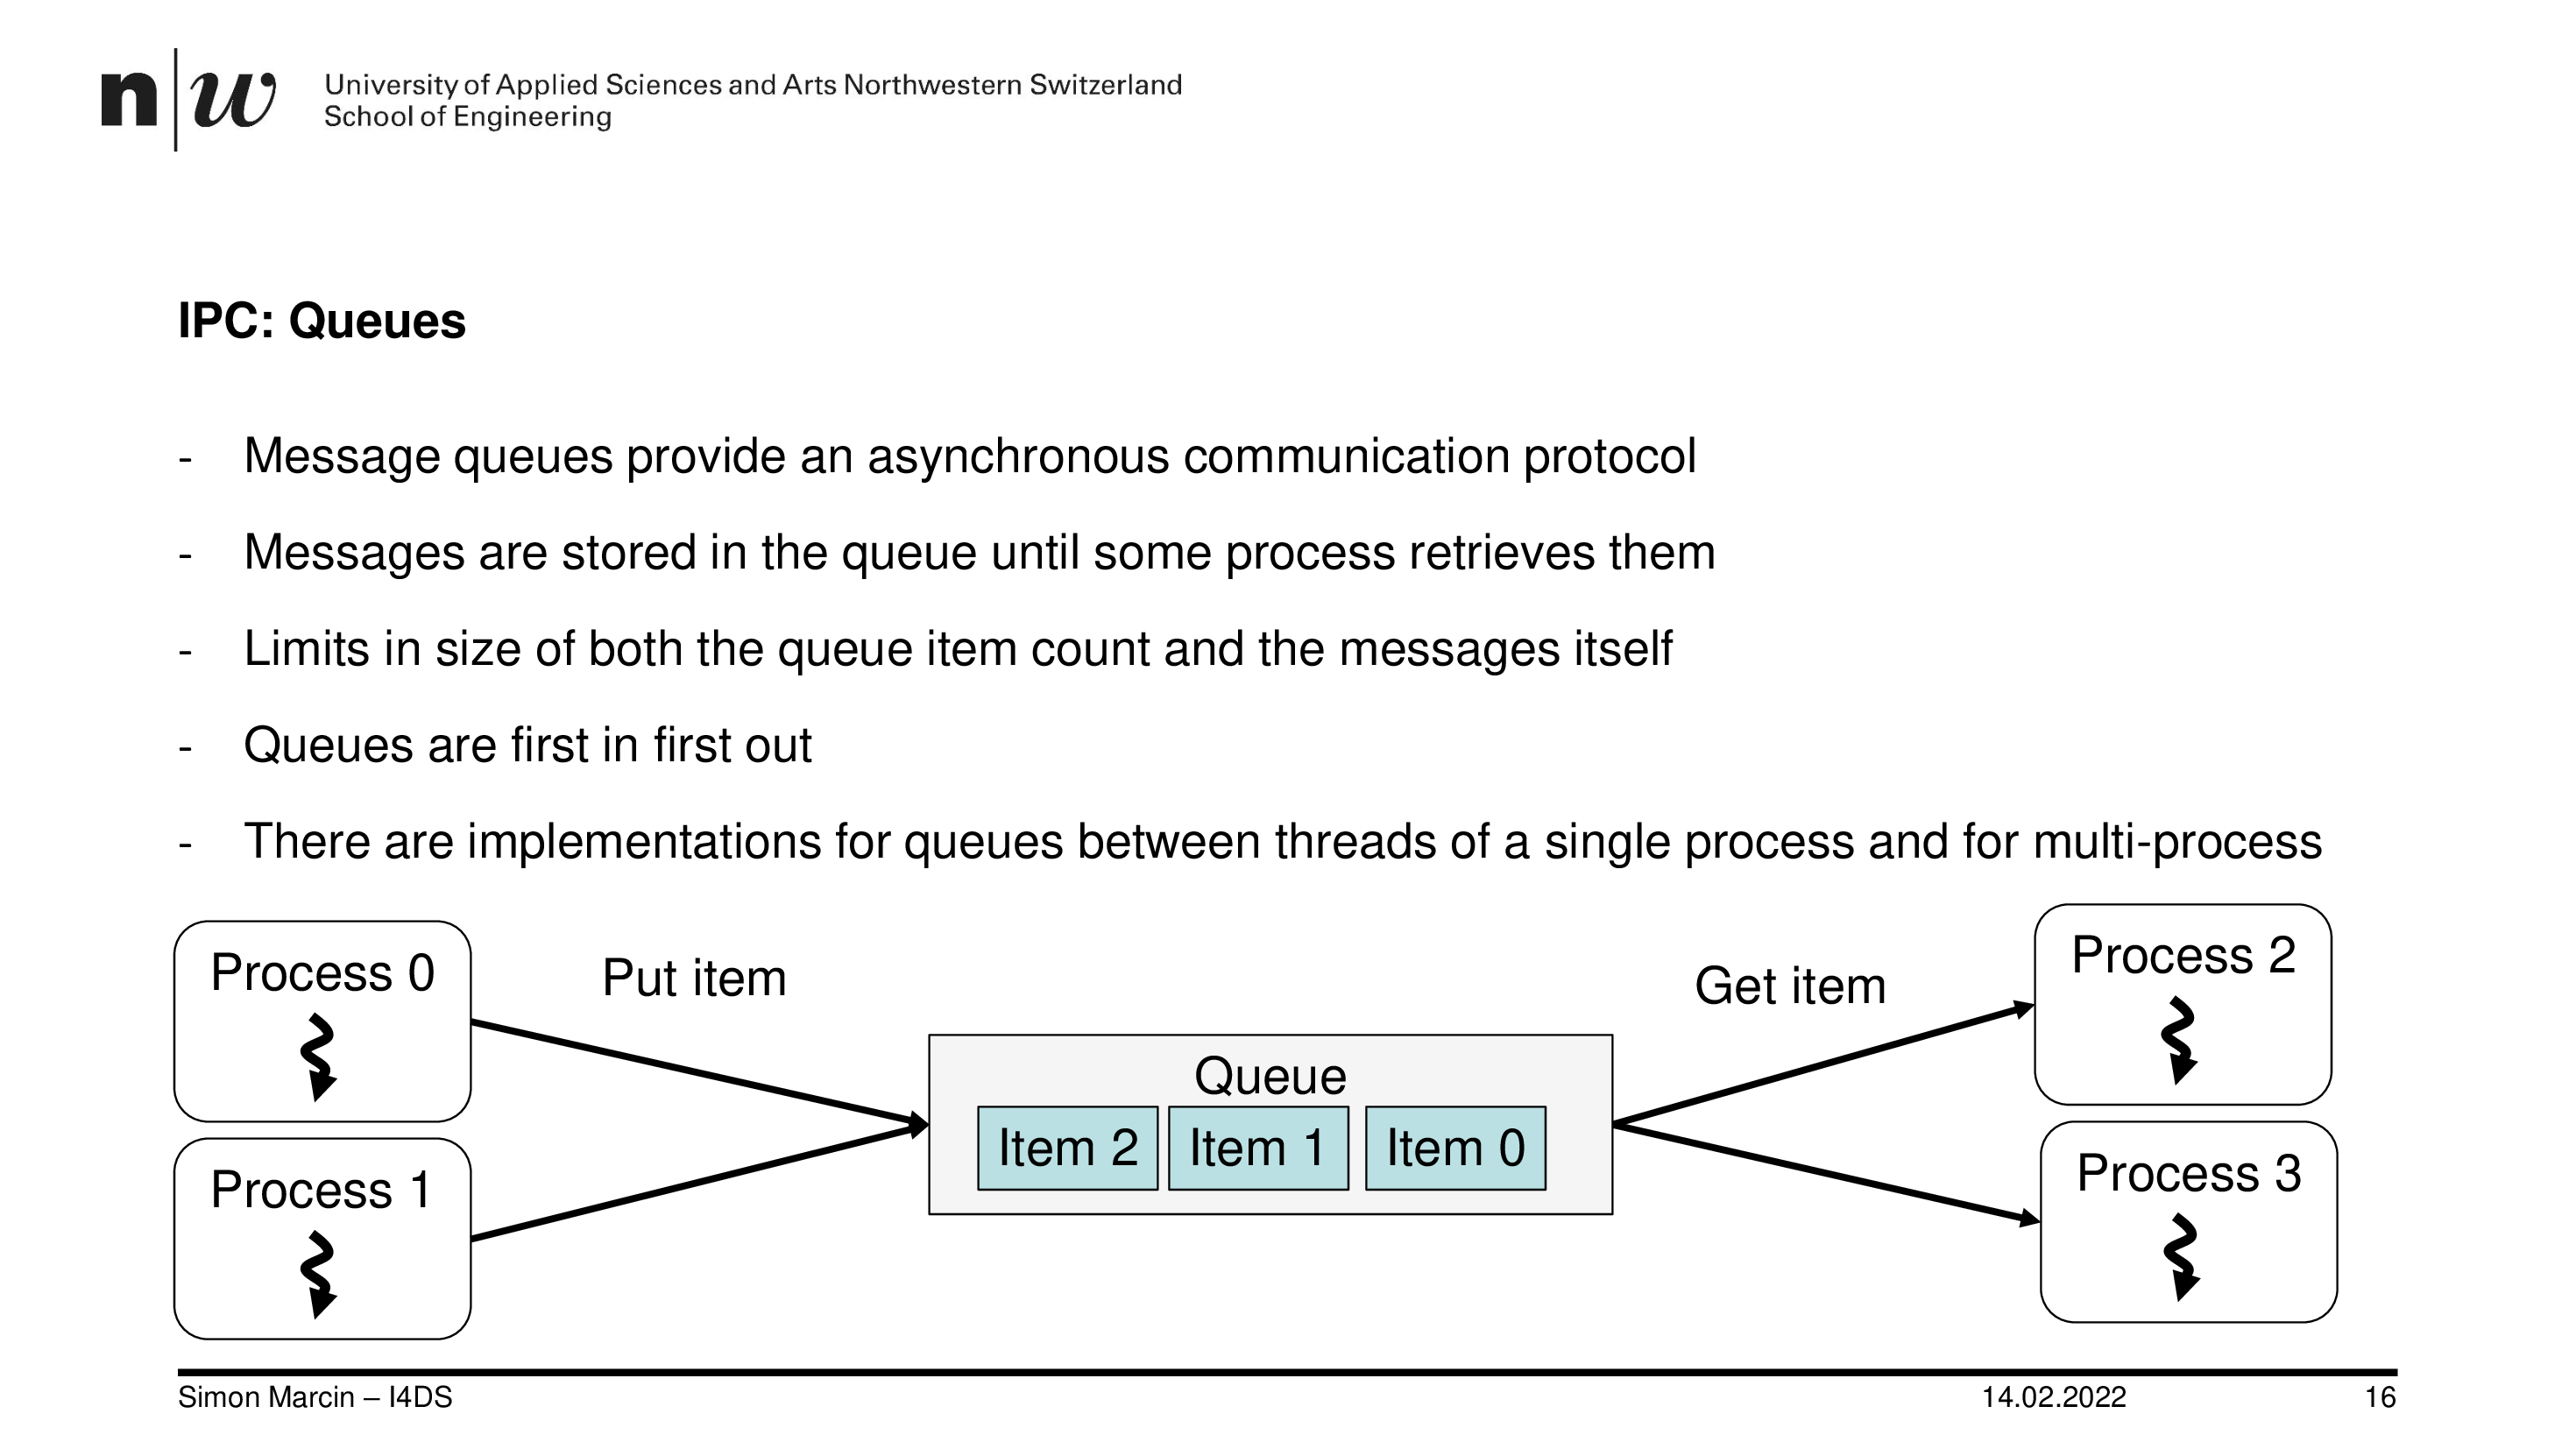

In [16]:
WImage(filename="01_IPC.pdf[15]", resolution=200)

#### Queues
Queues are used to pass messages between threads or processes. There can be multiple producers and multiple consumers. The following code illustrates this by filling the Queue within the main thread and open N other threads to consume them.

In [42]:
#import the thread safe queue module
import queue
import time
import random

def consume(q):
    """
    Consume items out of q until receiving the item "END". Do a random sleep after each item.
    q:    a thread safe Queue object
    """
    while True:
        try:
            item = q.get(False)
        except queue.Empty:
            print(f"Thread {threading.get_ident()} found an empty queue and exit.")
            break
        print(f"Thread {threading.get_ident()} processed item {item}")
        if item.startswith("END"):
            break
        time.sleep(random.random())
            

def produce(q, n):
    """
    Produce n items and put them into the Queue q. Add n time the item "END" to the end of q.
    q:    a thread safe Queue object
    n:    number of items to add 
    """
    for i in range(n):
        q.put(f"Item_{i}")
        print(f"Put Item_{i} into queue.")
    for i in range(n):
        q.put(f"END_{i}")
        print(f"Put END_{i} into queue.")

#Init Queue and run threads
q = queue.Queue()
n_threads = 3
produce(q, n_threads * 2)
helper_start_n_threads(n_threads, consume, args=(q,))

Put Item_0 into queue.
Put Item_1 into queue.
Put Item_2 into queue.
Put Item_3 into queue.
Put Item_4 into queue.
Put Item_5 into queue.
Put END_0 into queue.
Put END_1 into queue.
Put END_2 into queue.
Put END_3 into queue.
Put END_4 into queue.
Put END_5 into queue.
Thread 140189259257600 processed item Item_0
Thread 140189267650304 processed item Item_1
Thread 140189501683456 processed item Item_2
Thread 140189259257600 processed item Item_3
Thread 140189267650304 processed item Item_4
Thread 140189267650304 processed item Item_5
Thread 140189267650304 processed item END_0
Thread 140189501683456 processed item END_1
Thread 140189259257600 processed item END_2


**ToDo:** What happens if you do not have the "END" item in the queue? Do you have another solution for this? Check: https://docs.python.org/3/library/queue.html#queue-objects

In [43]:
#ToDo: remove "END" items


**ToDo**: Try to change the code that you not only have multiple consumers, but also multiple producers which feed items into the queue.

In [44]:
#ToDo: Implement multiple producers and multiple consumers.


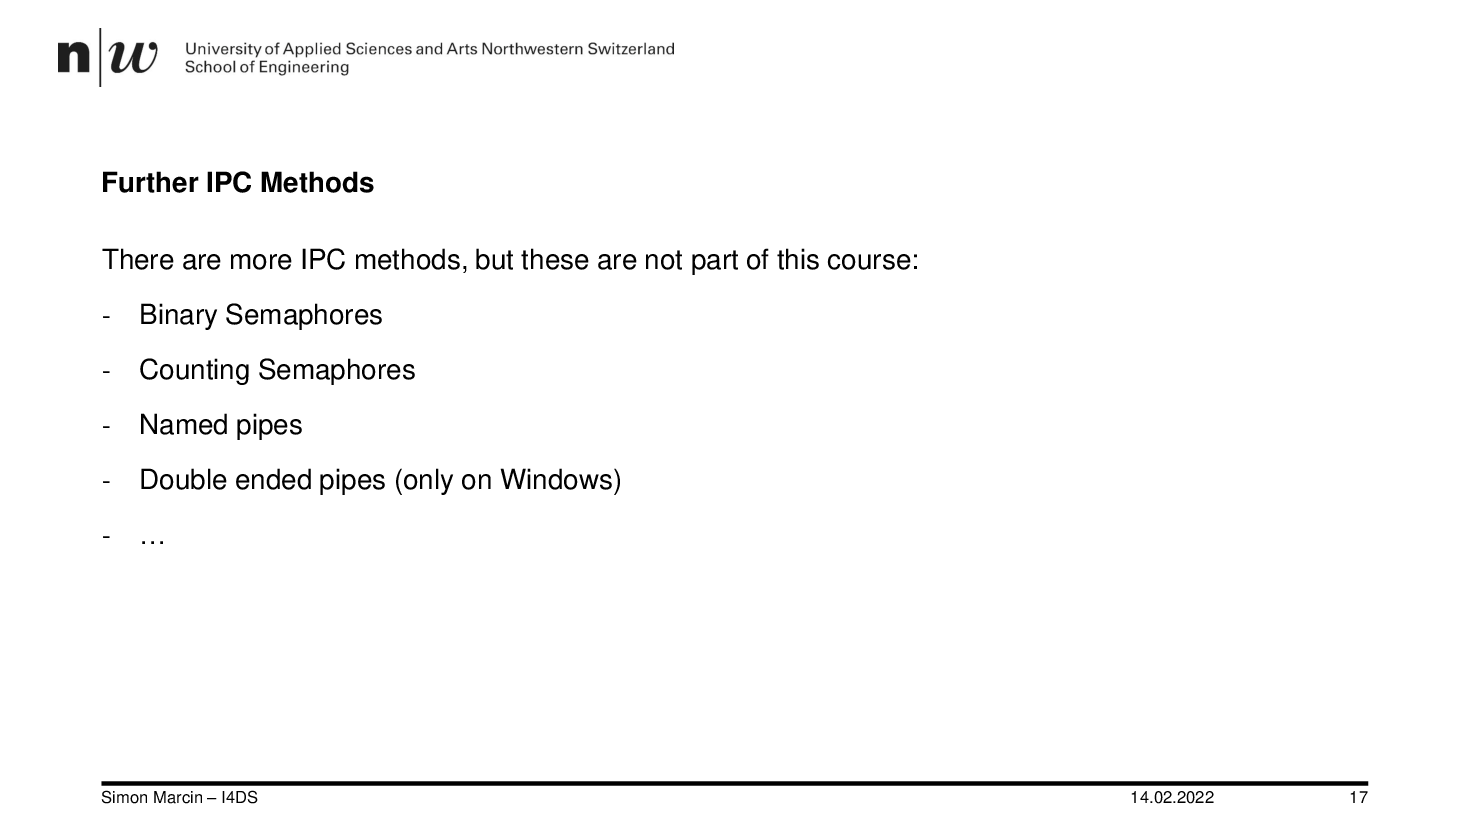

In [17]:
WImage(filename="01_IPC.pdf[16]", resolution=100)

**ToDo:**
Cab you fix the Race-Condition expample with the function `add_n_times_1` with the knowledge of above?

In [92]:
#Fix Race-Condition example add_n_times_1
